# GG4257 - Urban Analytics
---
## Assignment 2
---

### Lab 6: Geodemographics

Lab 6 served as an introduction to geodemographic modelling. This allows us to analyse populations at the neighbourhood scale. It also introduced the k-means clustering method, which is a way of grouping data into clusters of similar characteristics (working on the assumption that people with similar characteristics group together).

### Contents:

- <a href="#All-packages-needed-to-run-this-code:">Packages</a>
- <a href="#Challenge-1:">Challenge 1</a>

---


### All packages needed to run this code:

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

---

### Challenge 1: 
**1. Define the main goal for the geodemographic classification (marketing, retail and service planning).**

   
I've decided to keep the theme of my previous lab and pick York in England as my city to work through these tasks with. I'm going to focus on sorting populations to find best places/populations to focus charitable efforts.

**2. Look for census data from the selected city for which you would like to generate the geodemographic classification.**

Finding data from Infuse through the UK Data Service (Infuse, 2024)

**3. The census data at the Output Area OA level. Select multiple topics of at least four topics (socio-demographics, economics, health, and so on). Describe your topic selection accordingly based on the goal of your geodemographic classification. For example, if your geodemographics are related to marketing, economic variables might be the appropriate selection.**


To carry out a geodemographic modelling of York, I have selected the following datasets from the England and Wales Census from 2011 (UK Data Service, 2011). The range in topics should allow for an effective geodemographic model of York to be formed, which will subsequently allow us to create klusters to view where would be most effective for new social services to be place or aid schemes to be put into effect. 

The data will be imported from CSV format, and joined to a shapefile of output area boundaries in York to allow for successful mapping of the data. 


| Data | Topic | Description | 
| ------ | --- | --- |
| Age | Demographic | Data regarding age is often seen as one of the main characteristics that should always be included within studies of demographic data. |
| Sex | Demographic | Same as age, sex is often regarded as a core demographic characteristic to be included in all demographic studies. |
| Marital Status | Demographic | This data includes matrial and civil partnership statuses, seen as important here as seperated invidivuals with dependent children may require more help with childcare etc. |
| Household composition | Household | Household composition (like marital status too) might be able to suggest where more support for families is required, by identifying households with fewer adults and more dependents.  |
| Car or Van Availability | Household/Economic | Car or van availability per household can be a useful economic indicator, areas with fewer vehicles owned may need better supported public transport for residents. |
| Tenure | Household/Economic | Allows us to see the distribution of homeownership/renters. Measured here by household rather than by individual. An area with increased rates of renting or areas of social housing might require more access to social services and financial aid. |
| Number of Persons Per Bedroom | Household/Economic | Describes the average number of people per bedroom in a household. Allows us to view the distribution of households that may have over overcrowding issues |
| Economic Activity | Economics | Economically inactive individuals (or economically active but unemployed individuals) may require more support from social services. |
| General Health | Health | A measure of self-rated health. Those with lower self-rated health could required more support with day to day activities. |
| Long Term Health Issues | Health | This measure provides a count for how many people have long-term health issues that provide limitations for their day to day activities. As with the previous measure of health, knowing which areas have more people with health problems can allow aid and services to concentrate within those areas. |
| Highest Level of Qualification Achieved | Education | Places with higher populations of individuals with no formal qualifications may need more support or training to secure a job. |
| Deprivation Classification of Household | Combination | This data shows how many households fall into multiple classifications of deprivation, including measures of employment, education, health, and housing. This is a good alrounder measure, as households that fall into more classifications of deprivation might require more support from social and charitable services |

In [ ]:
# starting with reading in all the csv files

# defining the directory where all the csv files are and putting all the files in a list
#york_csv_directory = "data/lab6/"
#york_csv_files = [file for file in os.listdir(york_csv_directory) if file.endswith(".csv")]

# initiallising an empty dataframe
#york_merged_data = pd.DataFrame()

# for loop to go through all csv files and add them into our dataframe
#for csv_file in york_csv_files:
#    york_csv_path = os.path.join(york_csv_directory, csv_file) # adapts the path for each file as we loop through
#    york_df_csv = pd.read_csv(york_csv_path, low_memory=False) # reads the file
#    york_merged_data = pd.concat([york_merged_data, york_df_csv], axis=1) # adds the file to our dataframe

# saving our new CSV file.
#york_merged_data.to_csv("data/lab6/results/york_merged_census_data.csv", index=False)

# hashtagged out because we've done this now so don't need to do it again!!

In [ ]:
# reading in our merged dataframe now
merged_csv_path = "data/lab6/results/york_merged_census_data.csv"
york_merged = pd.read_csv(merged_csv_path, low_memory=False)

# or alternatively
#york_merged = york_merged_data 

In [ ]:
# next reading the shapefile into a geodataframe
shapefile_york = "data/lab6/York_boundary_data/england_oac_2011.shp"
gdf_york = gpd.read_file(shapefile_york) #reading the shapefile into a geodataframe

In [ ]:
merged_gdf_york = gdf_york.merge(york_merged, left_on='code', right_on='oa_code', how='left')

In [ ]:
# saved as a shapefile - might have some issues with longer variables names being renamed
#merged_gdf_york.to_file('data/lab6/results/york_census_data.shp', index=False)

**4. Identify the variables that will be crucial for effectively segmenting neighbourhoods. Evaluate how this choice may impact the classification results, including a DEA analysis.**

When selecting variables, I wanted to start with a wide a range as I could, and so hence I aimed to included at least one variable from each downloaded CVS file with the knowledge that some of these would get cut when we started to look at correlations between variables. I wanted to be able to capture a range of different characteristics or circumstances or problems that would benefit from new social services or charitable efforts being placed in that area. For example, one of the variables chosen defines how many households within that output area have no access to a car or van. These households may benefit from services closer to home. I chose a variable looking at average number of people per bedroom in a household in order to look at overcrowding. Different variables concerning household compositions and the presence of dependents allow us to see which areas might benefit from an increase in childcare services, whereas the variable for qualifications might suggest that certain areas may benefit from increased provision of career or job support. 
Other variables are included as demographic studies generally benefit from them, e.g., the inclusion of variables for sex and age (although in hindsight the upper limit of age should maybe have been edited to be 65 and over to be more useful in this sceanario). All of these aid in the segmentation of York neighbourhoods, and each variable has been further checked to ensure a trend is visibile using univariate analyses shown below. 


In [ ]:
# making a list of all the variables we have to choose from - there's a lot of them!!
list(merged_gdf_york.columns)

In [ ]:
merged_gdf_york['No cars or vans in household'].describe() #having a little look at some of the variables

In [ ]:
merged_gdf_york['Age 30 to 44'].describe()

In [ ]:
merged_gdf_york['Age 90 and over'].describe()

In [ ]:
# plotting univariate analysis for each of the chosen variables 
attributes_to_plot1 = ['No cars or vans in household',
                      'Long-term health problem or disability: Day-to-day activities limited a lot',
                      'Bedrooms: Over 1.5 persons per bedroom',
                      'Economically active: Unemployed',
                      'Males',
                      'Females']

# initialising the figure - increased size in order to fit 6 histograms
plt.figure(figsize=(12, 8))

# for loop to plot each of the attributed defined in the list at the top of this cell
for i, attribute in enumerate(attributes_to_plot1, 1):
    plt.subplot(3, 2, i)
    sns.histplot(merged_gdf_york[attribute].astype(str), kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.show()

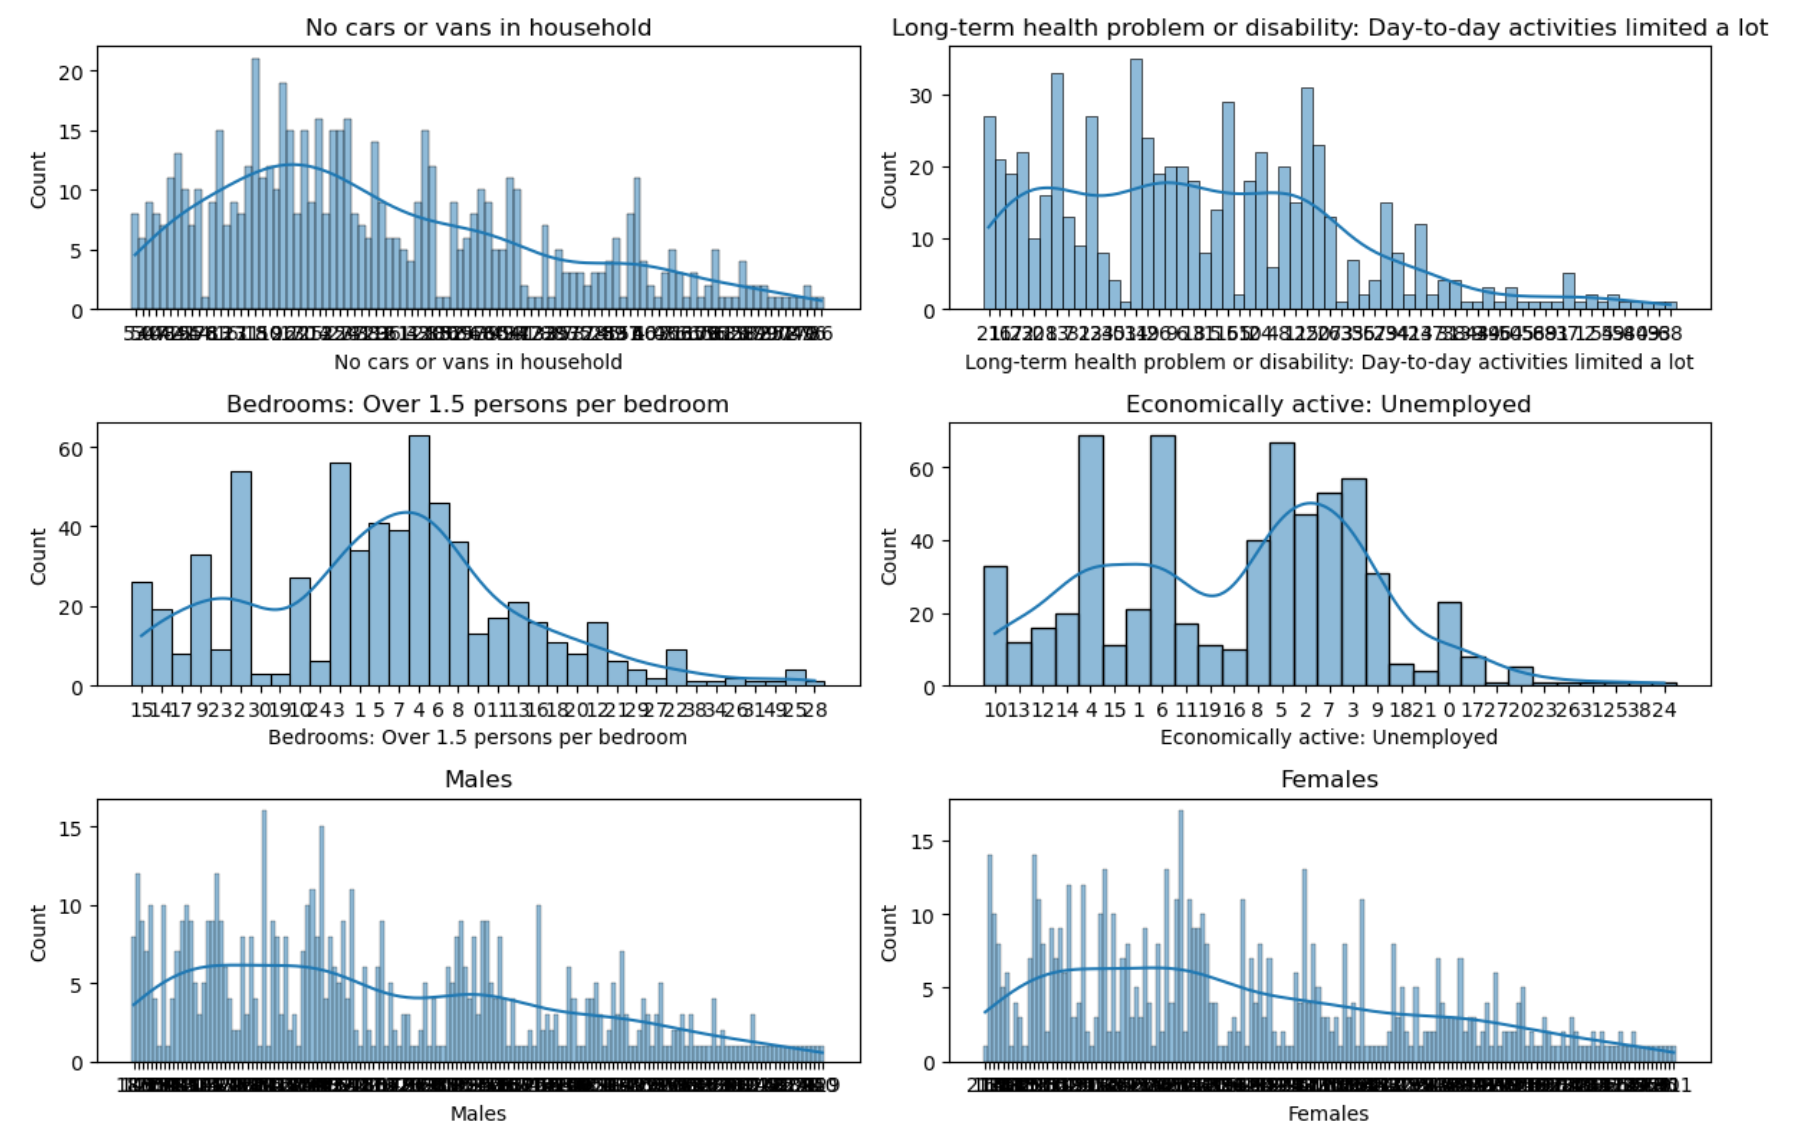

In [ ]:
# repeating with more attributes
attributes_to_plot2 = ['Marital status: Separated (but still legally married or still legally in a same-sex civil partnership)',
                      'Marital status: Divorced or formerly in a same-sex civil partnership which is now legally dissolved',
                      'Marital status: Widowed or surviving partner from a same-sex civil partnership',
                      'No qualifications',
                      'Deprivation: Household is deprived in 3 dimensions or more',
                      'One family only: Married or same-sex civil partnership couple: Dependent children'
                      ]

plt.figure(figsize=(12, 8))

for i, attribute in enumerate(attributes_to_plot2, 1):
    plt.subplot(3, 2, i)
    sns.histplot(merged_gdf_york[attribute].astype(str), kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.show()

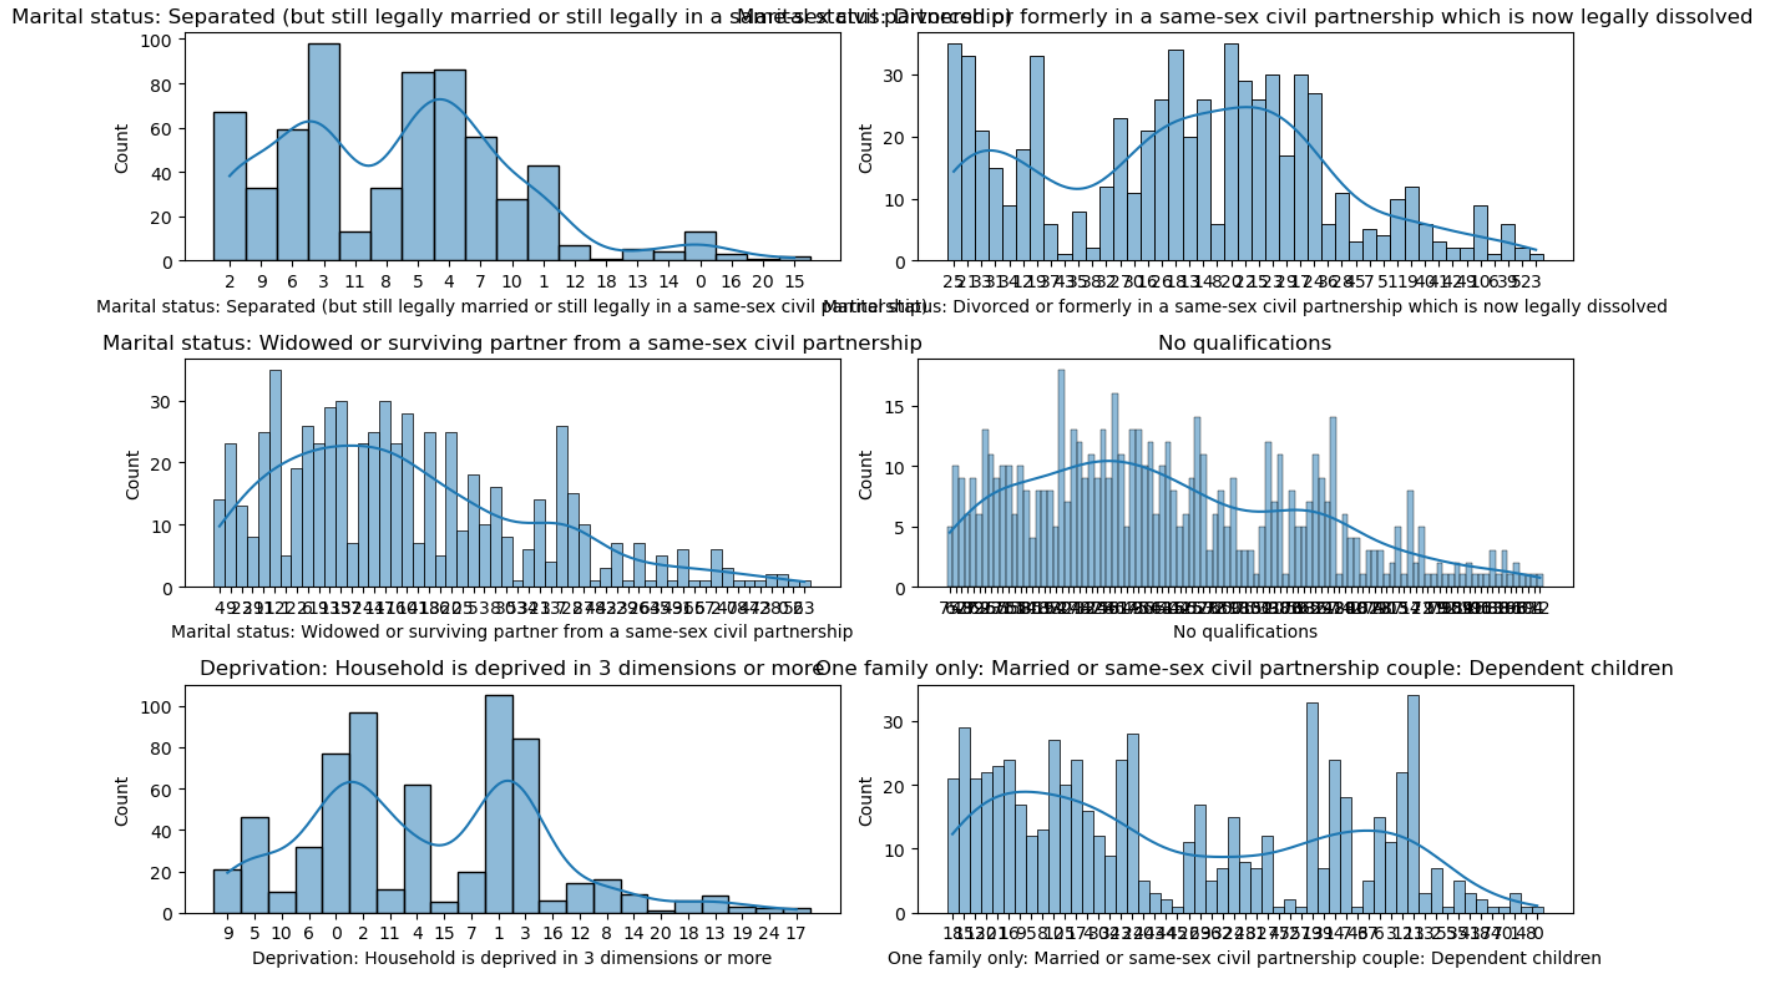

In [ ]:
# repeasting again with the last set of attributes
attributes_to_plot3 = ['One family only: Cohabiting couple: Dependent children',
                       'One family only: Lone parent: Dependent children',
                       'Other households: With dependent children',
                       'General health: Bad or very bad health'
                      ]

plt.figure(figsize=(8, 8))

for i, attribute in enumerate(attributes_to_plot3, 1):
    plt.subplot(3, 2, i)
    sns.histplot(merged_gdf_york[attribute].astype(str), kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.show()

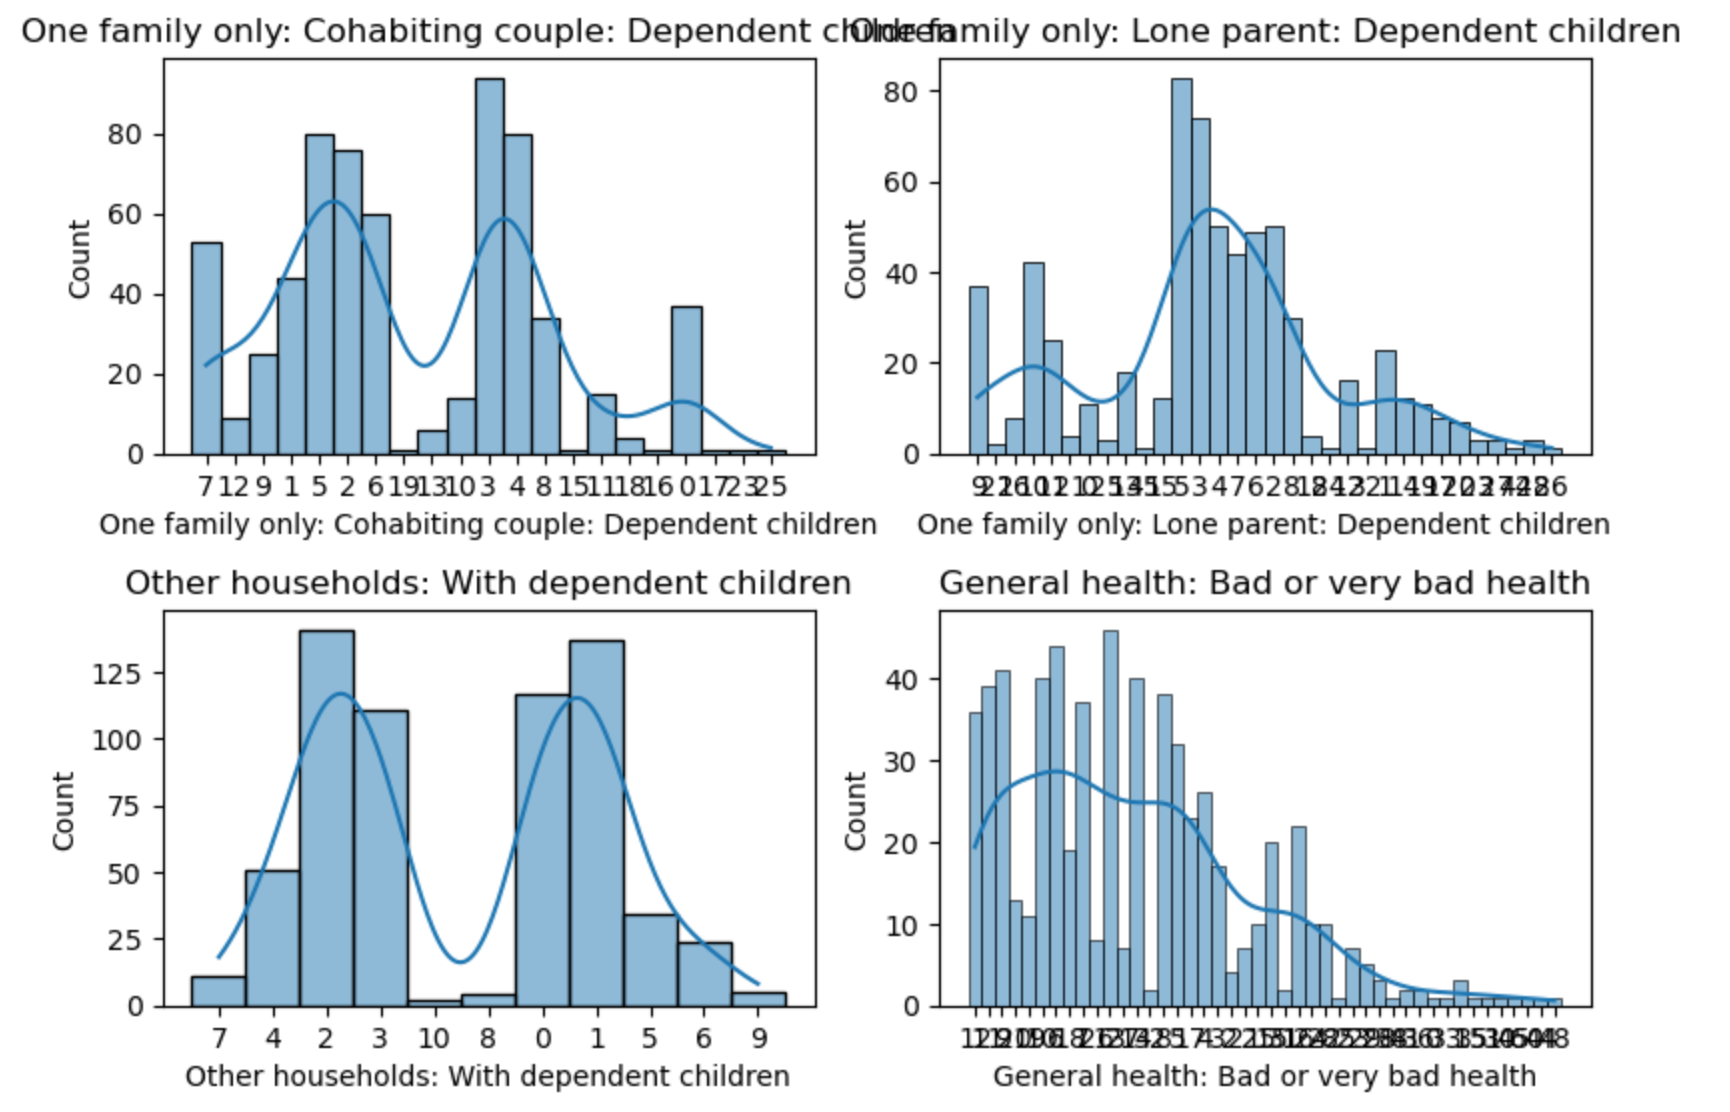

**5. Prepare, adjust or clean the dataset addressing any missing values or outliers that could distort the clustering results.**

In [ ]:
# the datasets all look good through their univariate anaylisis
# but we'll just check for the presence of NAs 
merged_gdf_york.isna().sum()
# looks like the only column with NAs is the 'name' but we will drop that one when we subset later!

**6. Include standardisation between areas and variables. Make an appropriate analysis and adjust the variable selection accordingly for any multicollinearity.**

To standardise variables between areas, we need to turn all of our raw count data into percentages that can be compared and analysed. 


In [ ]:
def calculate_percentages(dataframe, total_columns, value_columns): # function to calculate percentages

    result_df = pd.DataFrame() # initialises a new results dataframe

    for total_col, value_col in zip(total_columns, value_columns): # for loop to calculate percentages
        percentage_col_name = f"{value_col}_percentage"
        result_df[percentage_col_name] = (dataframe[value_col] / dataframe[total_col]) * 100

    # removed some of the validation and cleaning lines of code here as none of the columns we deal with have NaNs

    return result_df # returns the new dataframe

# List of the corresponding totals.
total_cols = ['Car or van: Total vehicles',
              'Long-term health problem or disability: Total',
              'Persons per bedroom: Total',
              'Economically active: Total',
              'Sex Total', 'Sex Total',
              'Marital status: Total aged 16 and over',
              'Marital status: Total aged 16 and over',
              'Marital status: Total aged 16 and over',
              'Qualification: Total age 16 and over',
              'Deprivation: Total',
              'Total households',
              'Total households',
              'Total households',
              'Total households',
              'General health: Total',
              'total', 'total'
              
             ]

# List of the corresponding values. 
value_cols = ['No cars or vans in household',
              'Long-term health problem or disability: Day-to-day activities limited a lot',
              'Bedrooms: Over 1.5 persons per bedroom',
              'Economically active: Unemployed',
              'Males', 'Females',
              'Marital status: Separated (but still legally married or still legally in a same-sex civil partnership)',
              'Marital status: Divorced or formerly in a same-sex civil partnership which is now legally dissolved',
              'Marital status: Widowed or surviving partner from a same-sex civil partnership',
              'No qualifications',
              'Deprivation: Household is deprived in 3 dimensions or more',
              'One family only: Married or same-sex civil partnership couple: Dependent children',
              'One family only: Cohabiting couple: Dependent children',
              'One family only: Lone parent: Dependent children',
              'Other households: With dependent children',
              'General health: Bad or very bad health',
              'Age 30 to 44', 'Age 90 and over'
              
             ]

 # filling our new dataframe with the output of the 
result_dataframe = calculate_percentages(merged_gdf_york, total_cols, value_cols)

In [ ]:
result_dataframe.shape # checking the shape, looks good

In [ ]:
result_dataframe.head() # checking the results - again all looking okay at the moment

In [ ]:
# join it to the merged dataframe!
concatenated_df = pd.concat([merged_gdf_york, result_dataframe], axis=1, ignore_index=False)
concatenated_df.head()

In [ ]:
concatenated_df.shape # checking the shape of the new concatenated dataframe

In [ ]:
list(concatenated_df.columns) # checking the columns - our % columns are now there and looking lovely

In [ ]:
# now that's all done, we'll subset the data set to only include the columns we need

keep_columns = ['oa_code',
                'geometry',
                'No cars or vans in household_percentage',
                'Long-term health problem or disability: Day-to-day activities limited a lot_percentage',
                'Bedrooms: Over 1.5 persons per bedroom_percentage',
                'Economically active: Unemployed_percentage',
                'Males_percentage',
                'Females_percentage',
                'Marital status: Separated (but still legally married or still legally in a same-sex civil partnership)_percentage',
                'Marital status: Divorced or formerly in a same-sex civil partnership which is now legally dissolved_percentage',
                'Marital status: Widowed or surviving partner from a same-sex civil partnership_percentage',
                'No qualifications_percentage',
                'Deprivation: Household is deprived in 3 dimensions or more_percentage',
                'One family only: Married or same-sex civil partnership couple: Dependent children_percentage',
                'One family only: Cohabiting couple: Dependent children_percentage',
                'One family only: Lone parent: Dependent children_percentage',
                'Other households: With dependent children_percentage',
                'General health: Bad or very bad health_percentage',
                'Age 30 to 44_percentage',
                'Age 90 and over_percentage'
                ]

york_census_data = concatenated_df[keep_columns]

In [ ]:
york_census_data.head()

In [ ]:
# renaming columns for easy data manipulation
rename_columns = { #defining a dictionary with columns and corresponding new names
                'No cars or vans in household_percentage': 'noVehicle',
                'Long-term health problem or disability: Day-to-day activities limited a lot_percentage': 'disaLimit',
                'Bedrooms: Over 1.5 persons per bedroom_percentage': 'overBedroom',
                'Economically active: Unemployed_percentage': 'unemployed',
                'Males_percentage':'males',
                'Females_percentage':'females',
                'Marital status: Separated (but still legally married or still legally in a same-sex civil partnership)_percentage': 'separated',
                'Marital status: Divorced or formerly in a same-sex civil partnership which is now legally dissolved_percentage': 'divorced',
                'Marital status: Widowed or surviving partner from a same-sex civil partnership_percentage': 'widowed',
                'No qualifications_percentage':'noQual',
                'Deprivation: Household is deprived in 3 dimensions or more_percentage':'deprived3dim',
                'One family only: Married or same-sex civil partnership couple: Dependent children_percentage':'marriedDepend',
                'One family only: Cohabiting couple: Dependent children_percentage':'cohabitDepend',
                'One family only: Lone parent: Dependent children_percentage': 'singleDepend',
                'Other households: With dependent children_percentage': 'otherDepend',
                'General health: Bad or very bad health_percentage':'badHealth',
                'Age 30 to 44_percentage':'age30to44',
                'Age 90 and over_percentage': 'ageover90'
                 }

# this line uses the dictionary we've just defined to rename columns
york_census_data = york_census_data.rename(columns=rename_columns)

In [ ]:
list(york_census_data.columns) # checking that all the column names have been changed - they have!

Next we need to calculate z-scores to create standardisation between variables!

In [ ]:
york_census_data.info() # data types look good so we can calculate z-scores for all float data!

In [ ]:
# calculating z scores and putting them in a seperate dataframe!
numeric_columns = york_census_data.select_dtypes(include='float64')
york_z_scores = (numeric_columns - numeric_columns.mean()) / numeric_columns.std(ddof=0)
york_z_scores.head()

Next we need to measure for association between variables, and remove variables that are colinear as these will reveal the same trends. We use pearsons coefficient to do this. We calculate pearsons coefficient and significance values for every pair of variables, to see if the are highly correlated or not.

In [ ]:
corr = york_z_scores.corr()
corr.style.background_gradient(cmap='coolwarm')

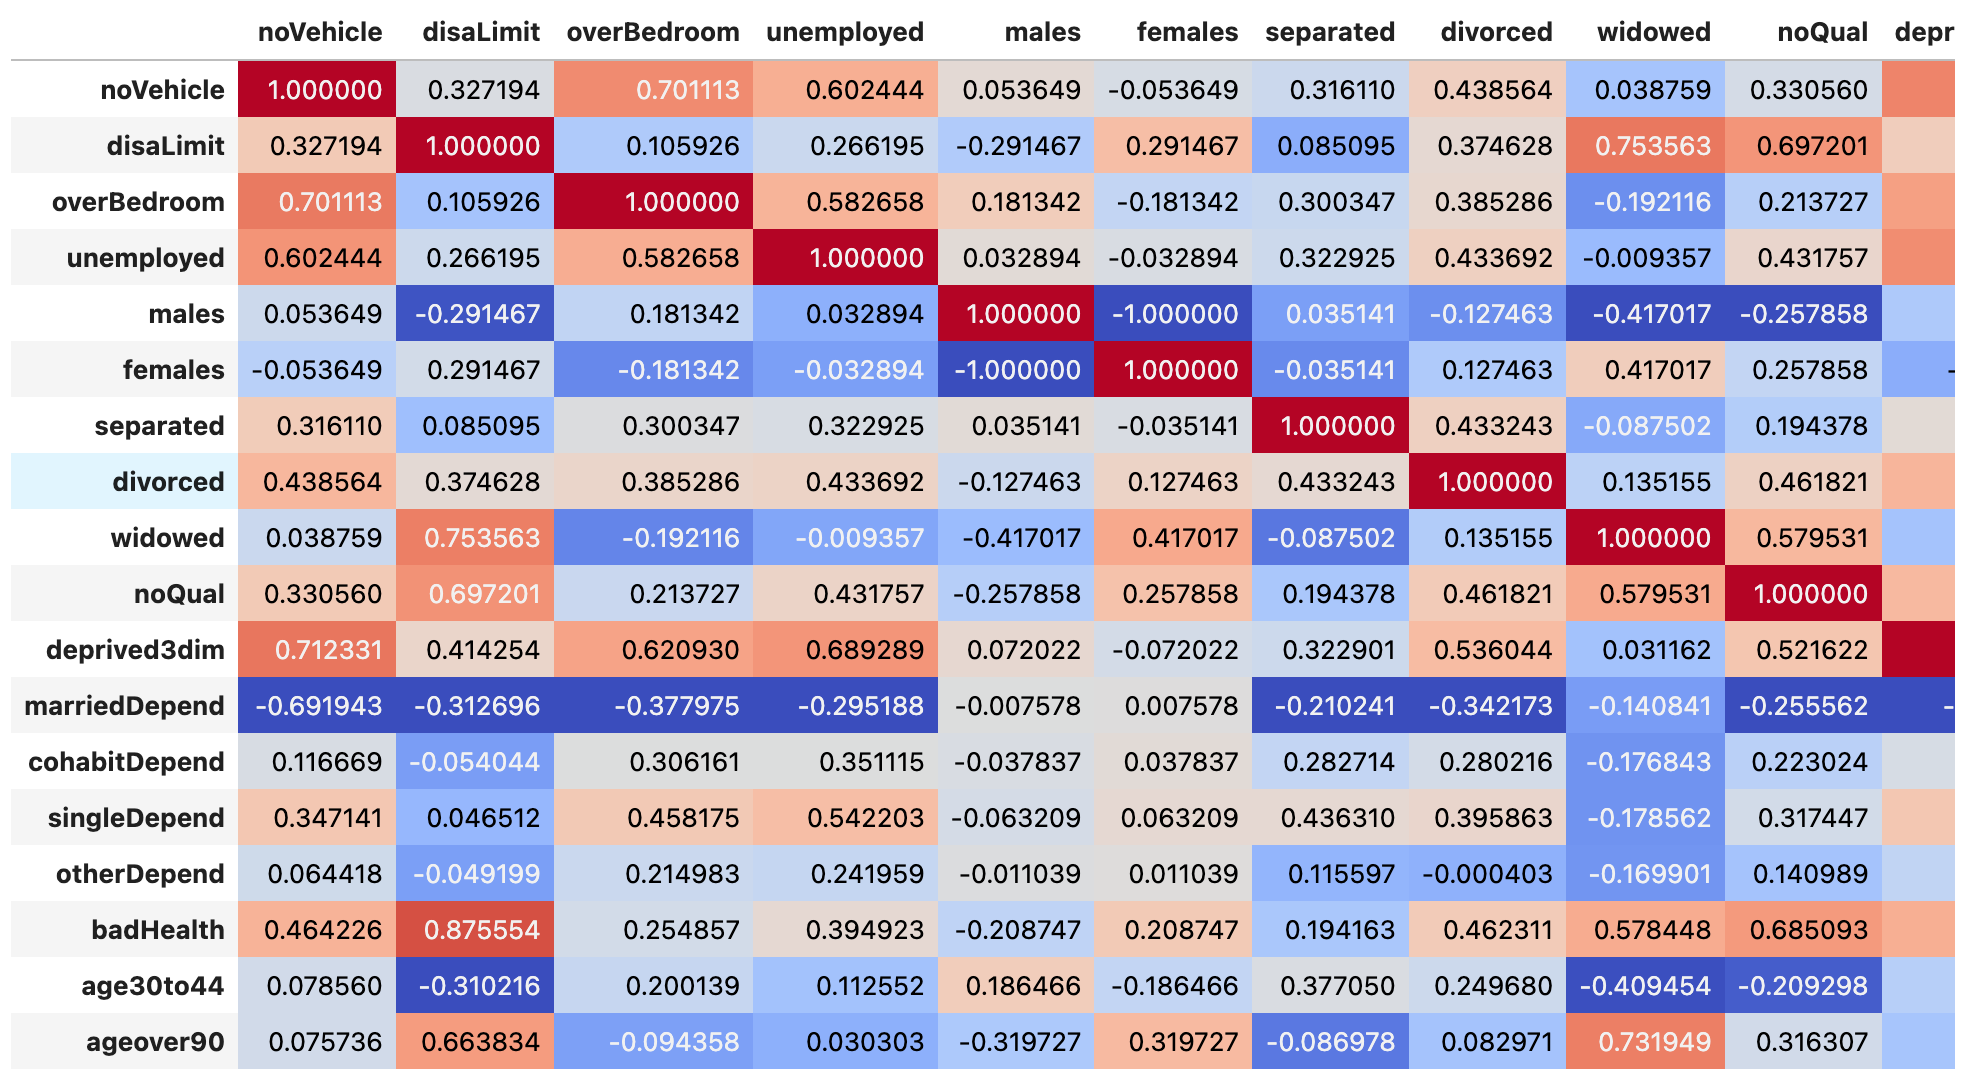
The above produced table of pearsons coefficients is useful in some ways, but it is difficult to read, and so we'll create a much more easily interpretable matric to represent our highly correlated values.

In [ ]:
threshold = 0.7
# Started with a threshold of 80% - gives us disaLimit and bad health highly correlated
# Taking it down to 70%, we also have overBedroom and noVehicle, widowed and ageOver90, 
#      widowed and disaLimit, and noVehicle and deprived3dim

highly_correlated = (corr.abs() > threshold) & (corr.abs() < 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(highly_correlated, cmap='coolwarm', cbar=False, annot=True)

plt.title('Highly Correlated Variables')
plt.savefig("images/matric.png") # saving the output as it's too large to screenshot
plt.show()



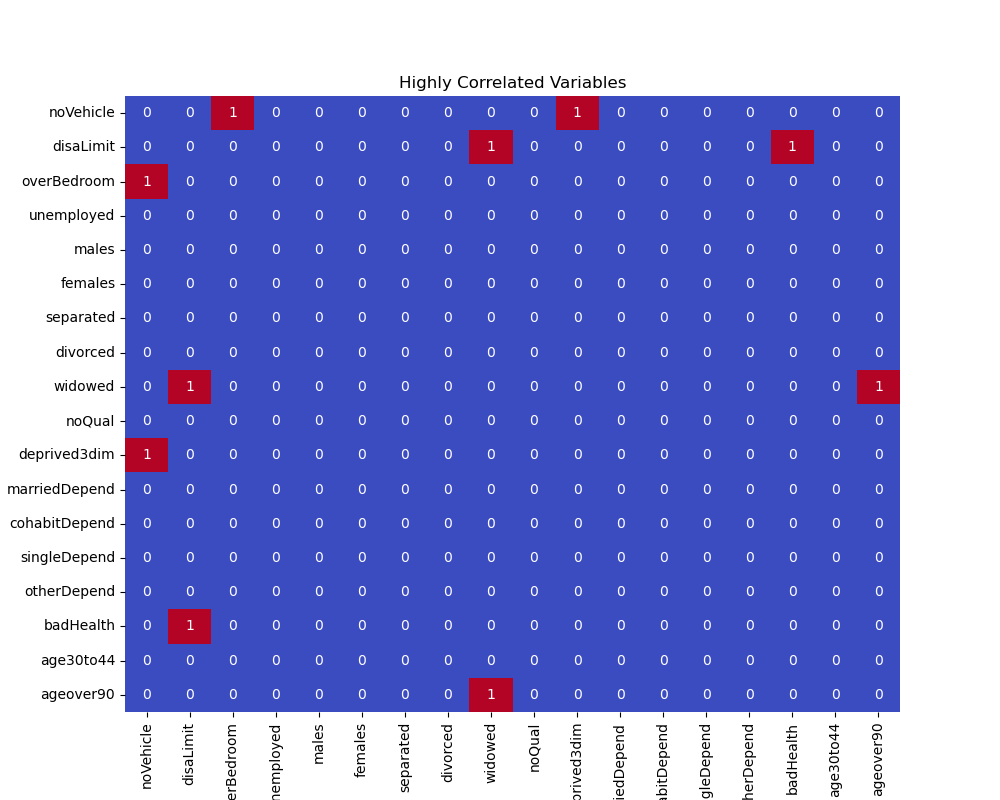The results of this multicolinearity analysis (set with a threshold for significance at 70%) allows us to conclude that the three most highly colerlated variables are 'widowed', 'noVehicle', and 'disaLimit'. Therefore, we will drop these three variables from our analysis.

In [ ]:
# dropping the three most highly correlated variables from the dataframe
york_z_scores.drop(['widowed', 'noVehicle', 'disaLimit'], axis=1, inplace=True)
york_z_scores.info() # checking they've been dropped - yep all looking good

In [ ]:
# double checking the new matrix
corr_2 = york_z_scores.corr()
corr_2.style.background_gradient(cmap='coolwarm')

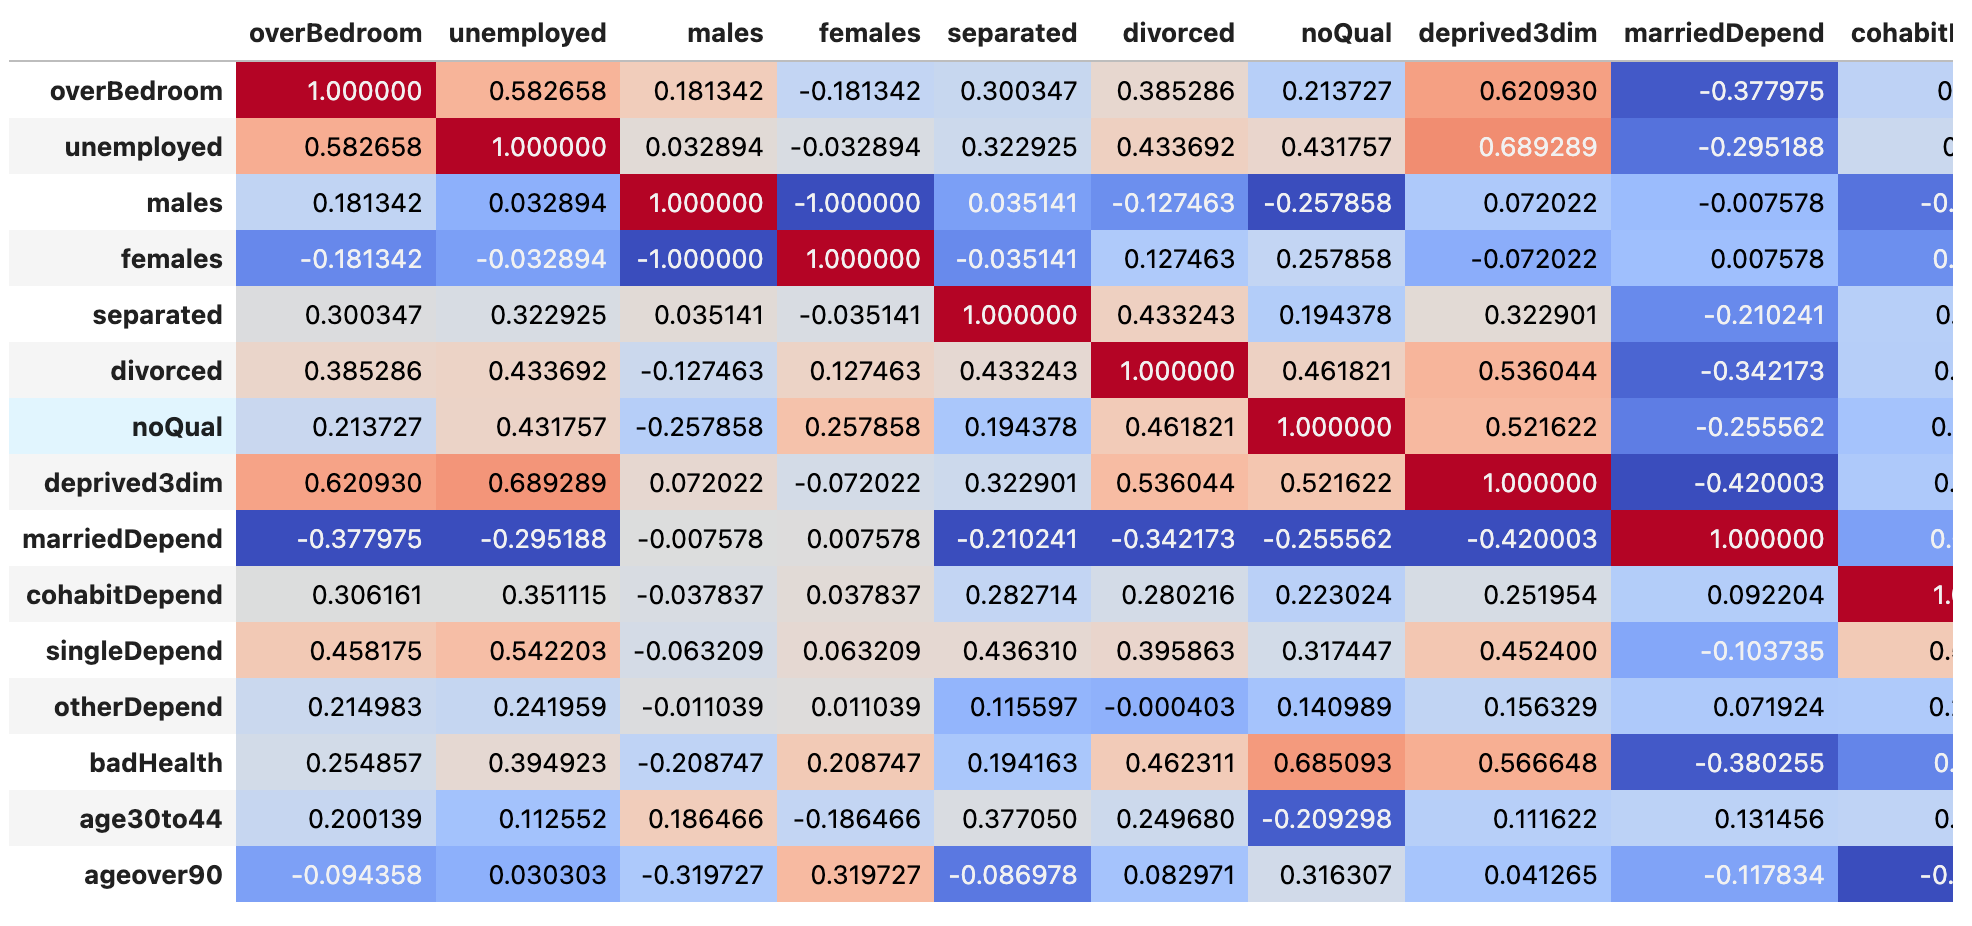

Checking this but again it's not the most useful output to us - let's have a look at the other matrix too!

In [ ]:
# checking again!
threshold = 0.7
highly_correlated_2 = (corr_2.abs() > threshold) & (corr_2.abs() < 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(highly_correlated_2, cmap='coolwarm', cbar=False, annot=True)

plt.title('New Highly Correlated Variables')
plt.savefig("images/matrix2.png")
plt.show()

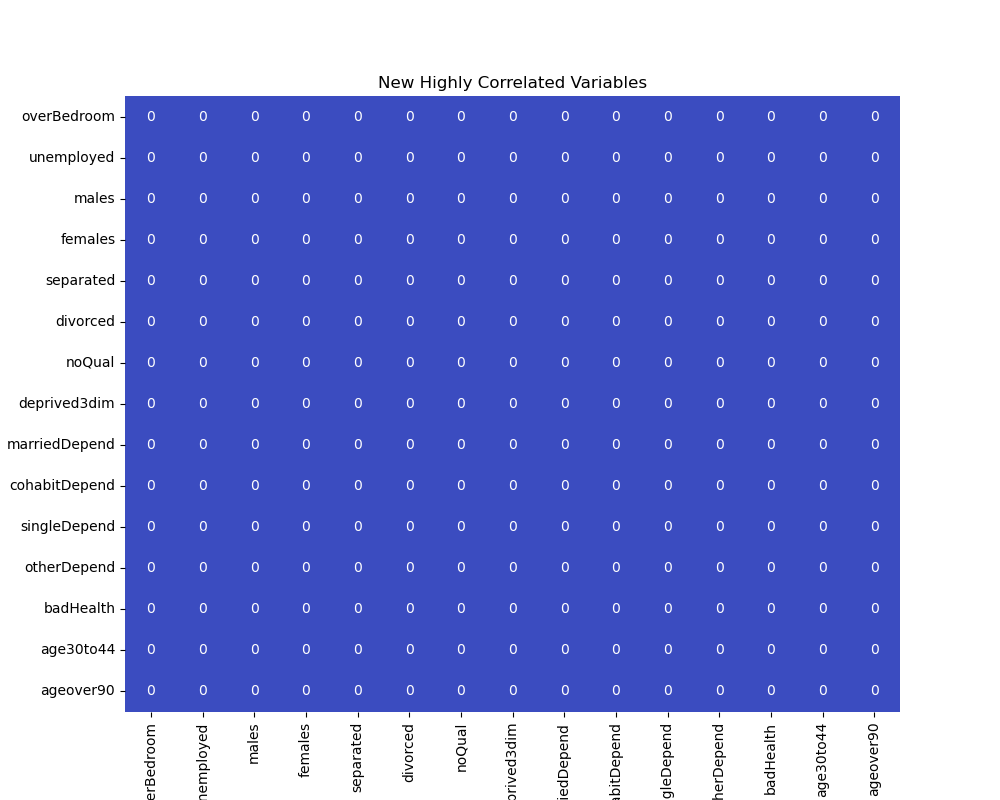
And success! We now have no highly correlated variables within our dataset. But now we've just got to the last bit of cleaning before we move on. We'll check for NaNs!

In [ ]:
york_z_scores.isna().any().any() 
# this line returns False, and so we can conclude that we don't have any NaN variables!

## K-means clustering (tasks 7 to 11)
**7. Utilize the k-means clustering algorithm to create a classification based on the selected variables.**

**8. Define the optimum number of clusters (i.e., using the Elbow method). Experiment with different values of k.**

Now we have a lovely completed dataframe of z scores for uncorrelated variables, we can start using the k-mean clustering method to create clusters of similar populations. Firstly we need to define the optimum number of clusters for out analysis. We will do this using the elbow method.

In [ ]:
Sum_of_squared_distances = [] # initialising an empty list

K_range = range(1,15) # creating a range for potential number of clusters cluster 

for k in K_range:
 km = KMeans(n_clusters=k)
 km = km.fit(york_z_scores)
 Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K_range, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

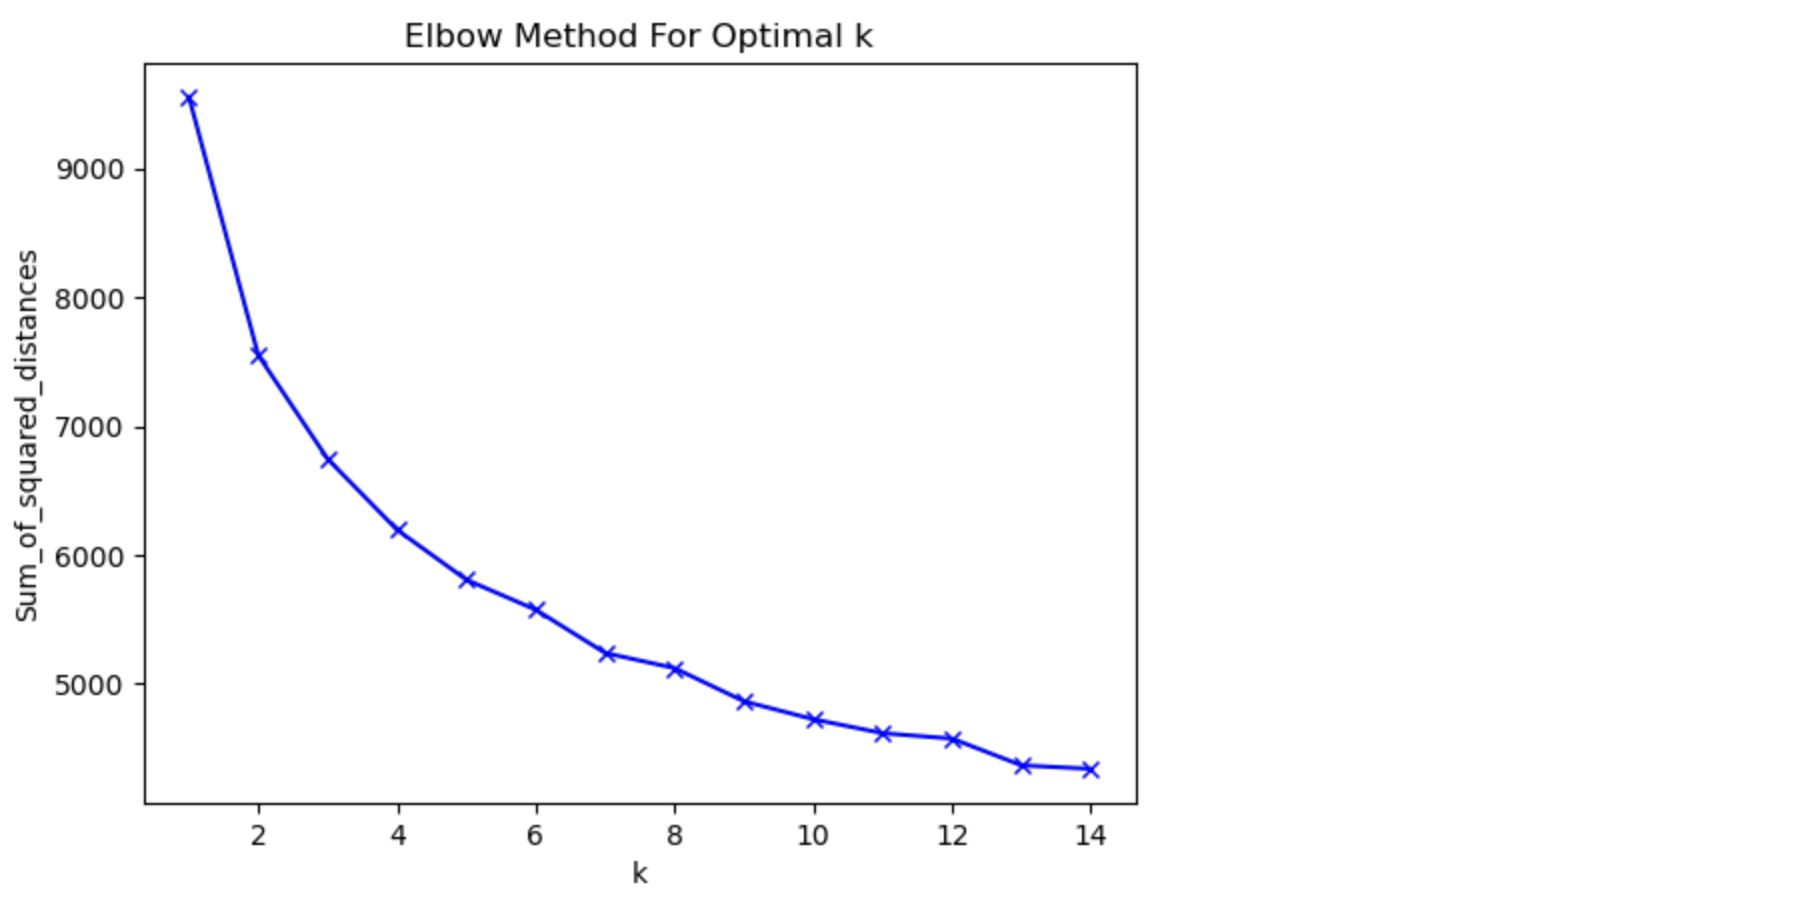

The above graph for measuring the optimal number of clusters prompts us to conclude that the optimal number of clusters for our analysis is 5, as after this, the line begins to plateau. The line steepens its drop between 6 and 7, but the sum of squared distances for 5 clusters when compared with 6 clusters is not dramatic enough to justify any more clusters than 5. 
However, we will also look at a graph summarising the between-cluster sum of squares to consolidate this.

In [ ]:
def elbow(dataframe, n): # defining a function for the elbow method
    kMeansVar = [KMeans(n_clusters=k).fit(dataframe.values) for k in range(1, n)] #making use of list comprehensions.
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(dataframe.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(dataframe.values)**2)/dataframe.values.shape[0]
    bss = tss - wcss
    plt.plot(bss)
    plt.xlabel('k')
    plt.ylabel('Between-cluster sum of squares')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 
elbow(york_z_scores,15)

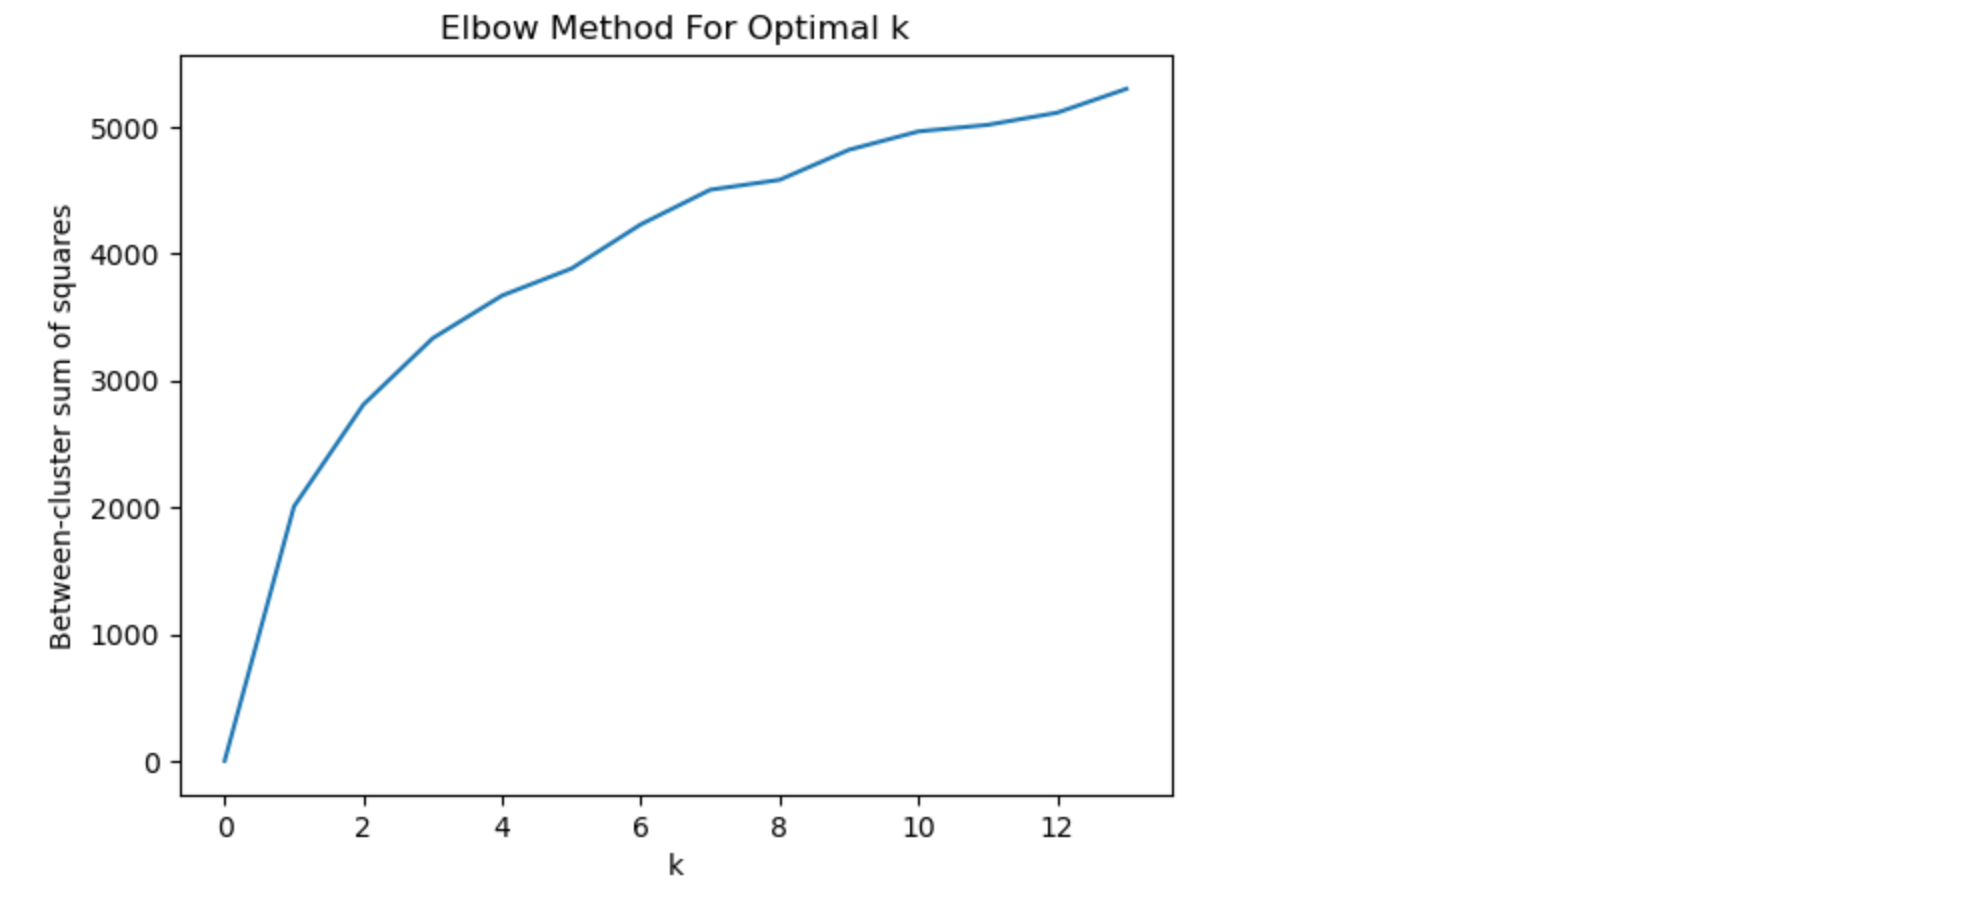
Analysis of between-cluster sum of squares reveals a similar trend as our initial elbow method graph, but this time a plataeuing of the trend when k exceeds 4. So within our analysis we will test different values for clusters and aim to have 5 perhaps 4 clusters. 

In [ ]:
# creating our cluster labels
kmeans = KMeans(n_clusters=5) # defining our cluster number as 5
kmeans.fit(york_z_scores)
labels = kmeans.predict(york_z_scores)
cluster_centres = kmeans.cluster_centers_

york_z_scores['Cluster'] = kmeans.labels_

In [ ]:
york_z_scores.head() # and there are our clusters looking lovely

In [ ]:
# going to export and save york_z_scores
york_z_scores.to_csv("data/lab6/results/york_z_scores.csv", index=False)

**9. Evaluate your cluster groups (e.g., using PCA) and interpret your cluster centres. Describe your results and repeat the process to adjust the variable selection and cluster groups to provide more meaningful results for your geodemographic goal. Interpret the characteristics of each cluster. What demographic patterns or similarities are prevalent within each group?**


In [ ]:
# USING PCA ANALYSIS

plt.figure(figsize=(12, 8))

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(york_z_scores)

york_z_scores['Cluster'] = clusters

scaler = StandardScaler()
stand_data_scaled = scaler.fit_transform(york_z_scores)

# These two lines of code carry out the actual PCA analysis
pca = PCA(n_components=2).fit(stand_data_scaled)
pca_result = pca.transform(stand_data_scaled)

#Percentage of variance explained by each of the selected components.
variance_ratio = pca.explained_variance_ratio_

# scatter plot for results!
fig = px.scatter(x=pca_result[:, 0], y=pca_result[:, 1], color=clusters,
                 labels={'color': 'Cluster'},
                 title='York Census: Cluster Plot against first two Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio.sum()*100):.2f}% of the point variability.")


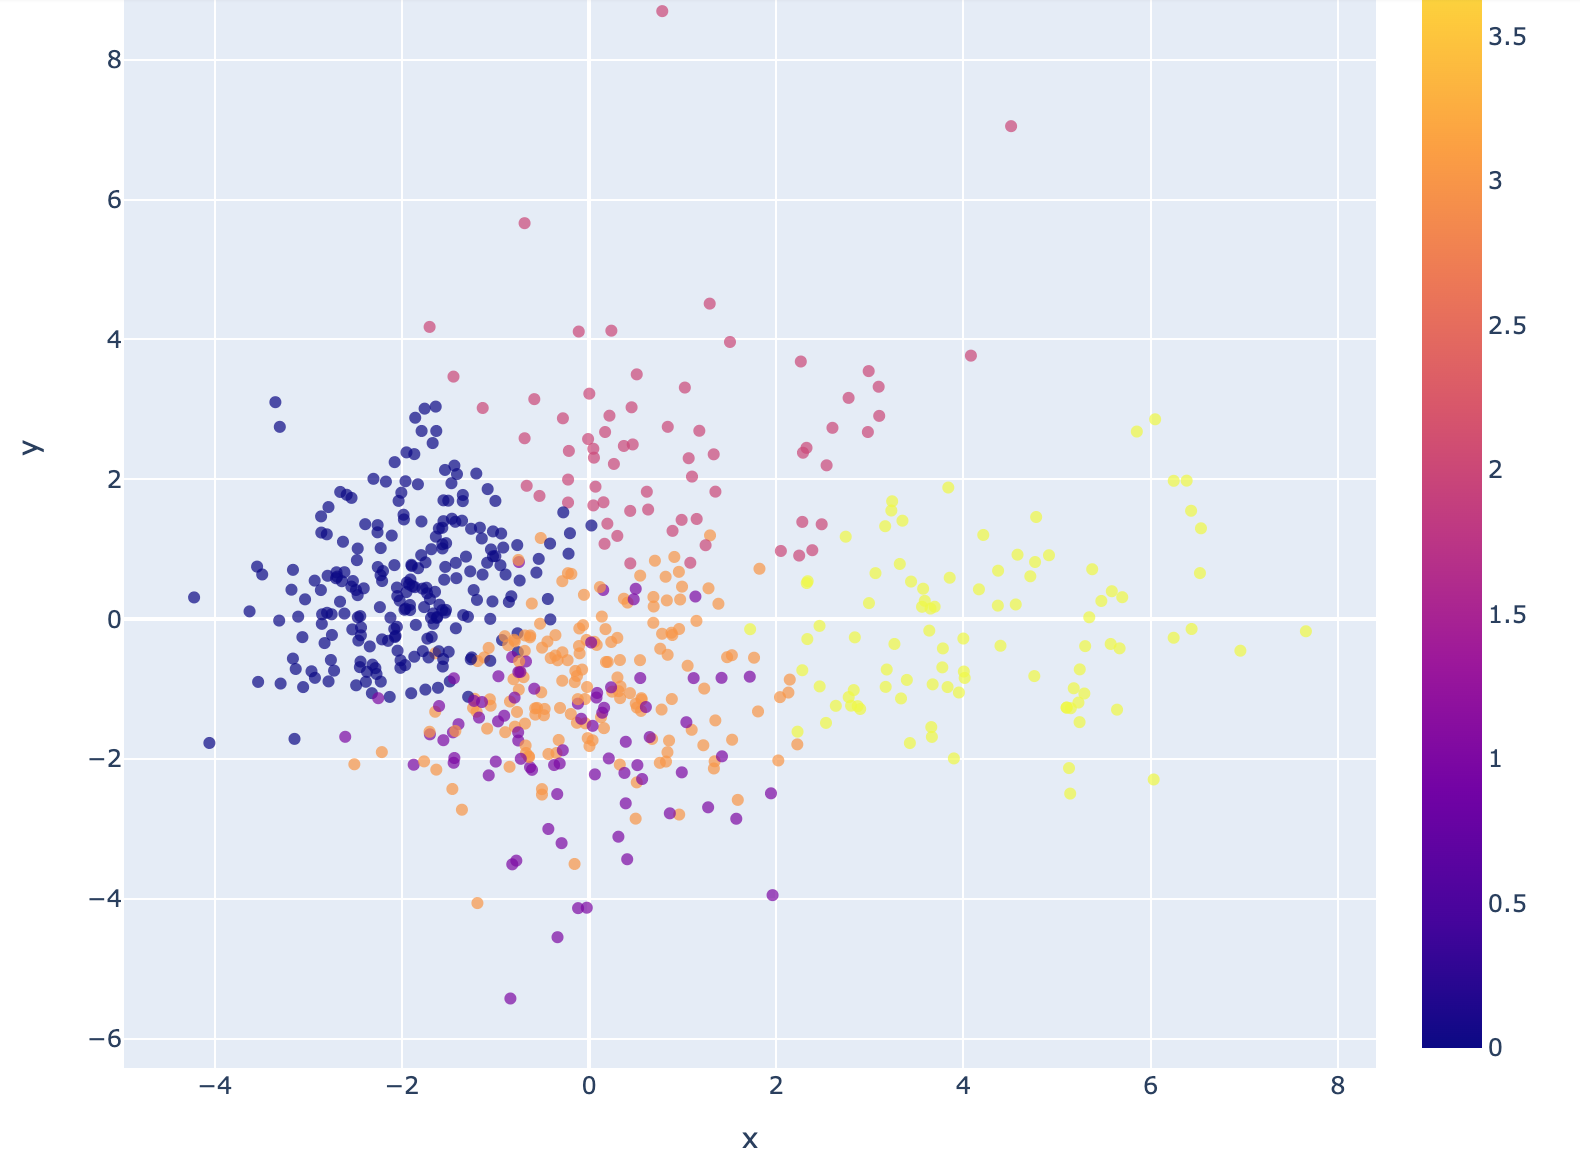
(graph extends upwards but cannot screenshot it all)

We can observe a lot of overlap in the above graph between clusters 1 and 3, they are almost entirely on top of each other, showing that they have the same point variance. Cluster 4 is a little more scattered, with variance extending upwards on the y axis, with 4 points lying quite far from the other points. Outliers perhaps?

In [ ]:
# interpreting the cluster centres

# Getting  cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=york_z_scores.columns)
cluster_centers.head()

Here I've had some trouble with clusters changing each time I ran the code, eventually after restarting the code and running through all the previous cells a few times (without making any changes), I realised the clusters were the same but they were swapping between labels. In an effort to solve this and progress with the challenge, I ended up exporting the dataframe with the cluster centers into a CSV, and reading it back in again. For more information, please see <a href="Info Page.ipynb#Lab-6:-Examples-of-where-clusters-seemed-to-go-wrong:">here</a>.

In [ ]:
# now this line has been run we don't need it again!
#cluster_centers.to_csv("data/lab6/results/cluster_centers.csv", index=False)

cluster_csv_path = "data/lab6/results/cluster_centers.csv"
cluster_pd = pd.read_csv(cluster_csv_path, low_memory=False)

In [ ]:
# LOOKING AT THE CHARACTERISTICS OF THE FIRST CLUSTER
first_row_centers = cluster_pd.iloc[0, :]

# saving the length of features
num_features = len(first_row_centers)

# getting the polar coordinates
theta = np.linspace(0, 2 * np.pi, num_features, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta, first_row_centers, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta, np.zeros_like(first_row_centers), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta)
ax.set_xticklabels(cluster_pd.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 1")
plt.show()

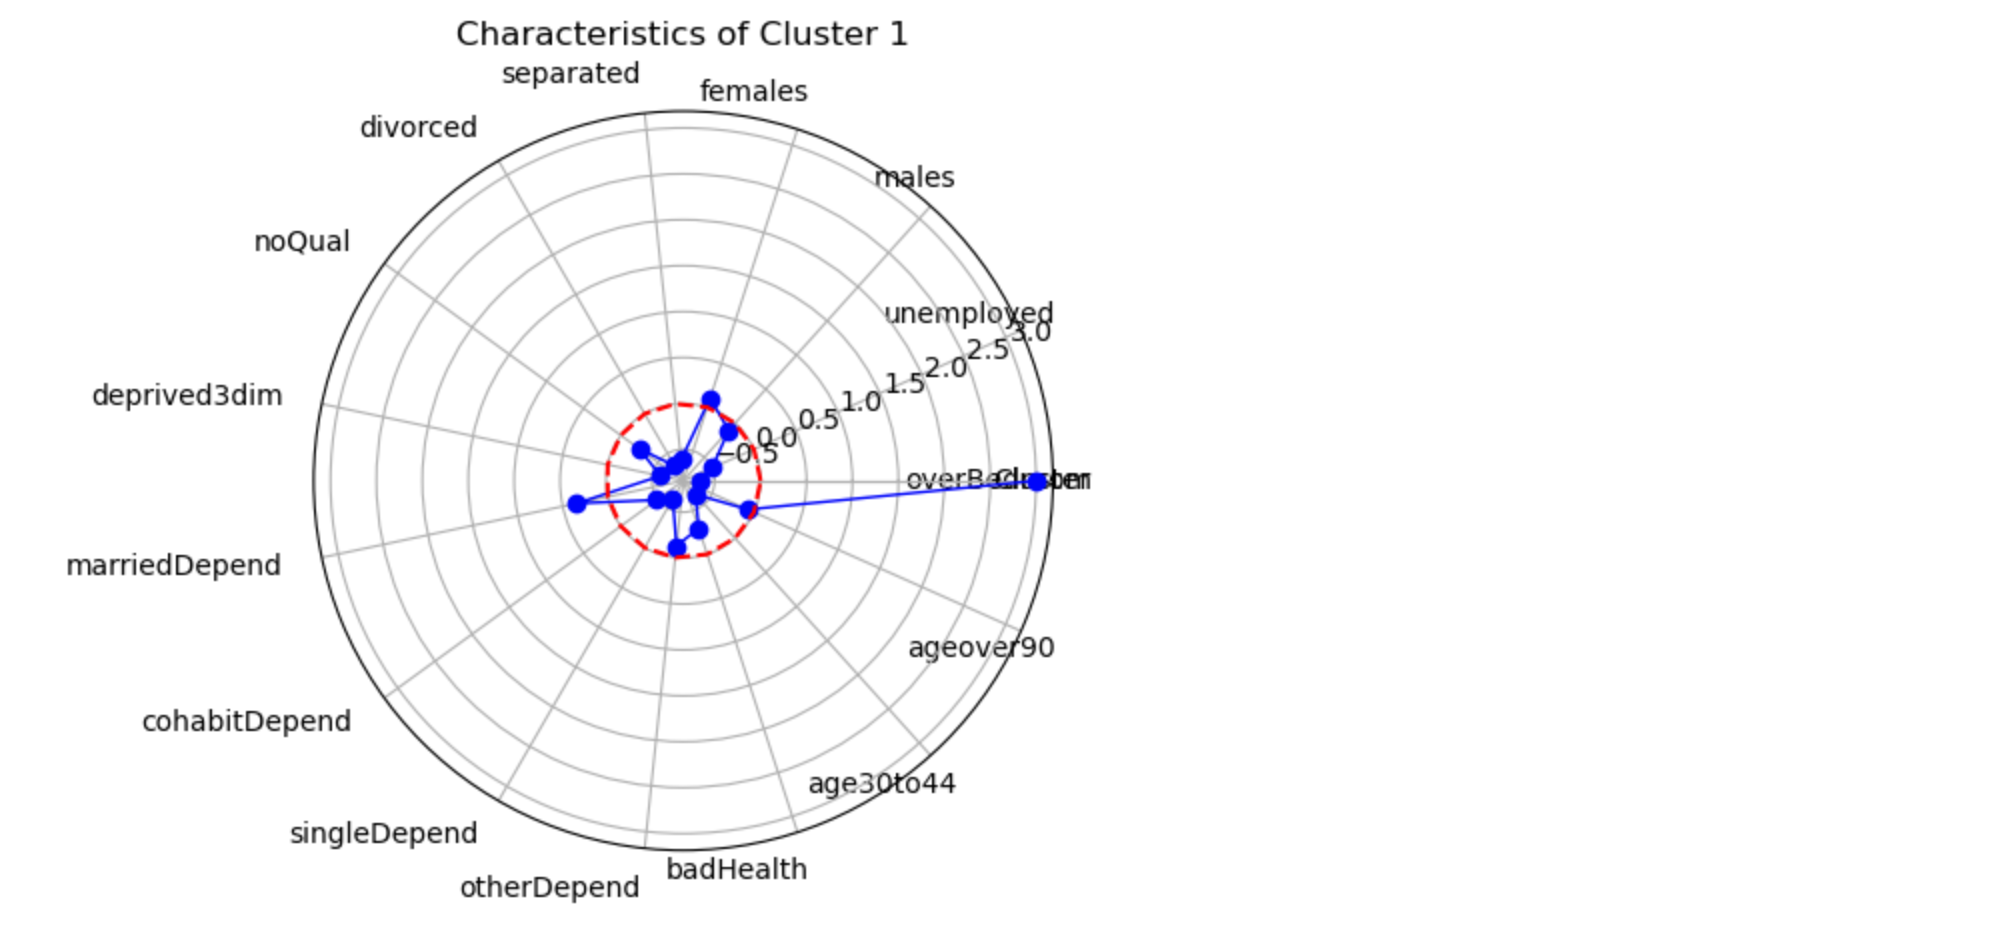This plot shows the characteristics making up the our first cluster! This appears to include households with a married couple with dependent children who are currently experiencing over crowding, who are not deprived in 3 or more dimensions, not reporting bad heath, not age 30 to 44, and with formal qualifications. Now we have this, we can move onto looking at our second cluster.

In [ ]:
# THE SECOND CLUSTER
second_row_centers = cluster_centers.iloc[1, :]
num_features2 = len(second_row_centers)

theta2 = np.linspace(0, 2 * np.pi, num_features2, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta2, second_row_centers, linewidth=1, color='blue', marker='o', label='Centers')

ax.plot(theta2, np.zeros_like(second_row_centers), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta2)
ax.set_xticklabels(cluster_centers.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 2")
plt.show()

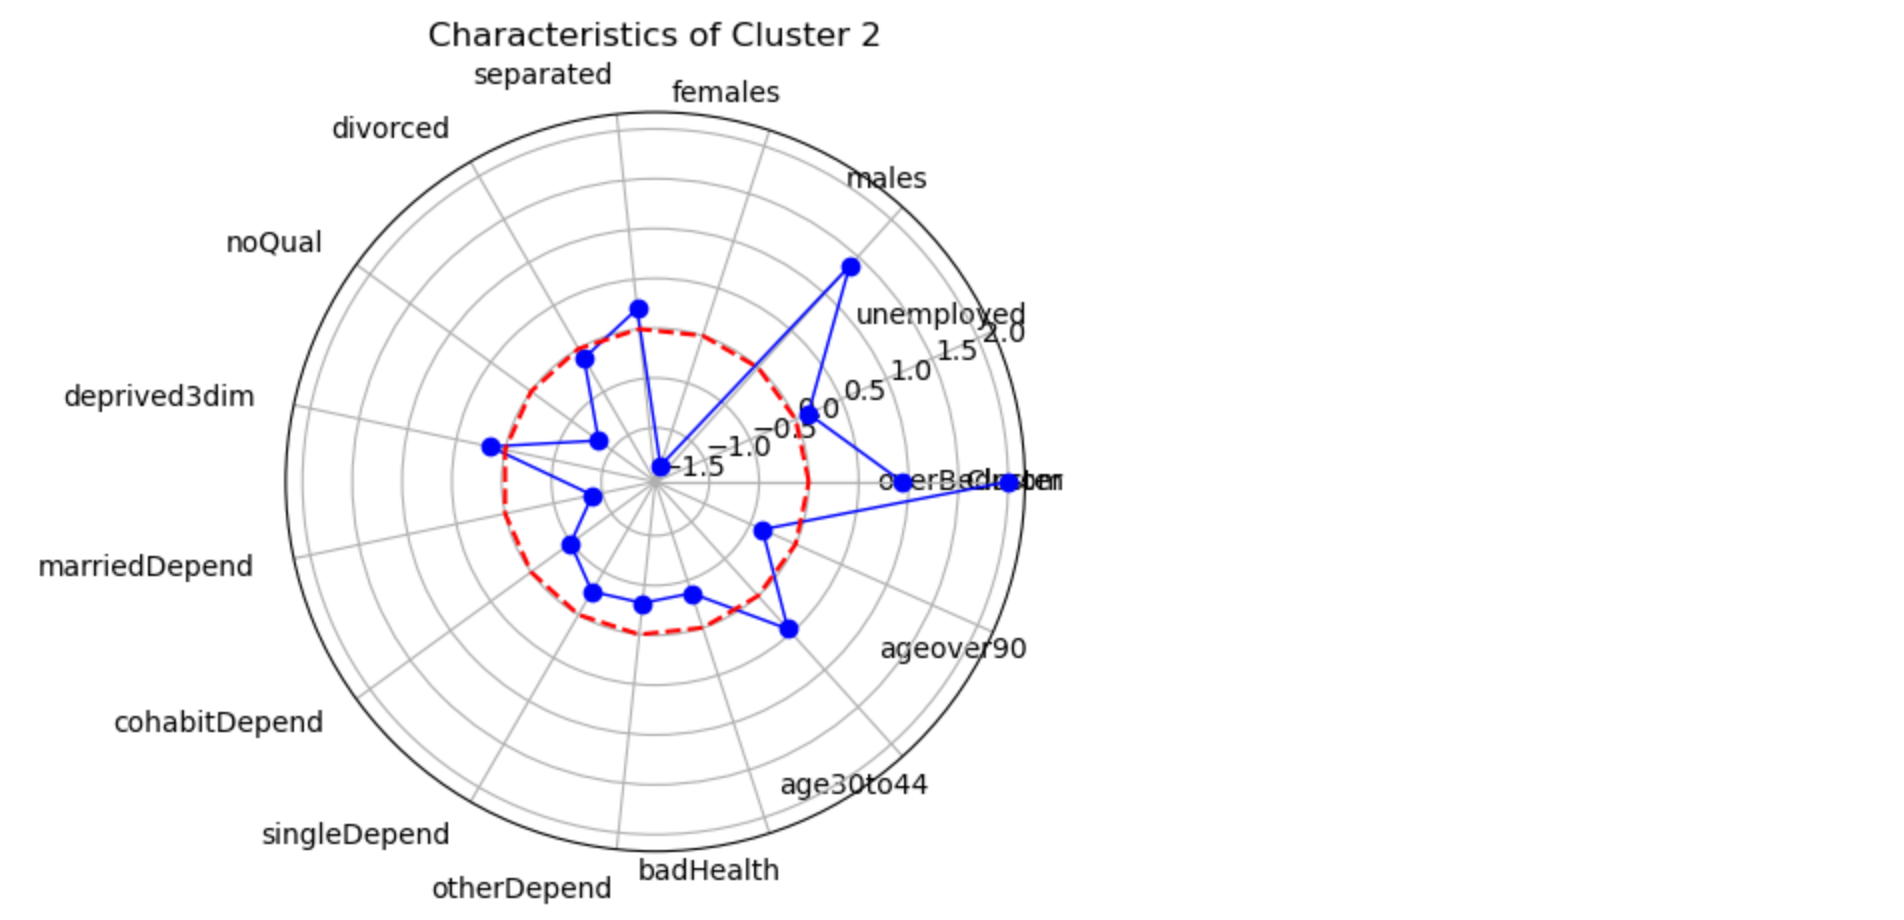
This description of the second cluster appears to focus more on males without dependent children between the ages of 30 and 44, living in households with more than 1.5 persons per bedroom. But we can mostly define this cluster by males and overcrowding. 

In [ ]:
# THE THIRD CLUSTER
third_row_centers = cluster_centers.iloc[2, :]
num_features3 = len(third_row_centers)

theta3 = np.linspace(0, 2 * np.pi, num_features3, endpoint=True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta3, third_row_centers, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta3, np.zeros_like(third_row_centers), color='red', linestyle='--', label='Avarage')
ax.set_xticks(theta3)
ax.set_xticklabels(cluster_centers.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 3")
plt.show()

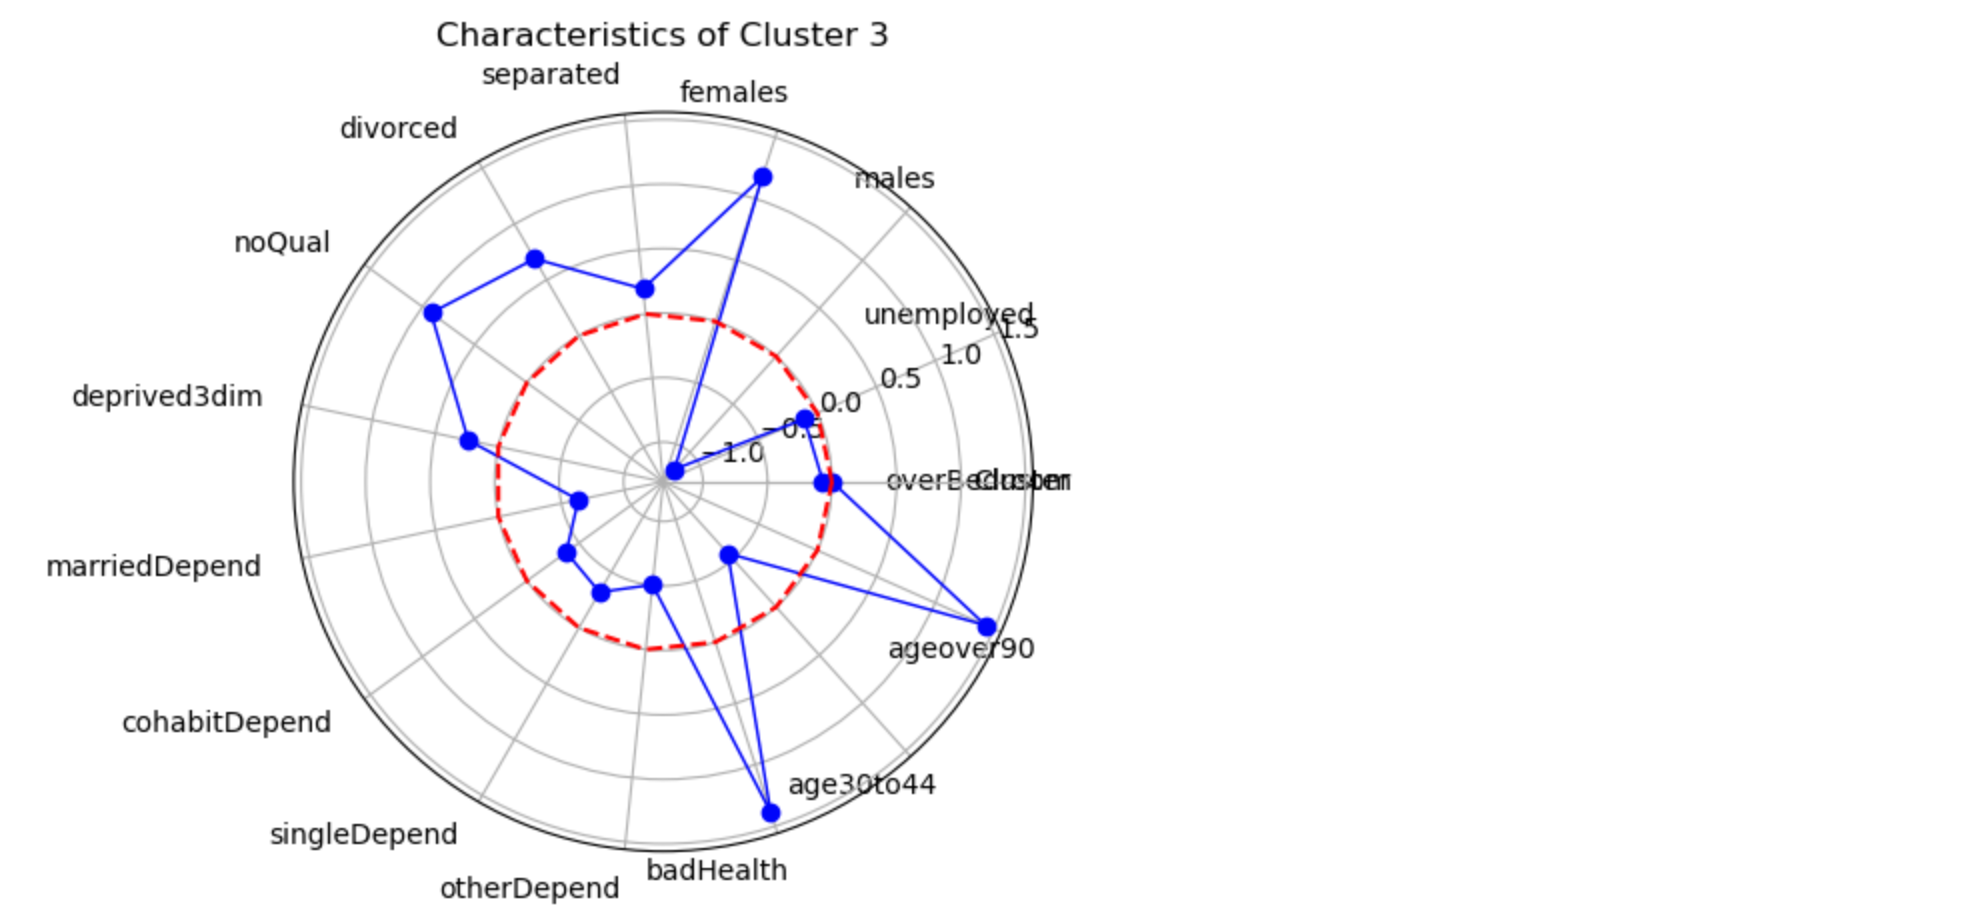
Cluster 3 has several defining features about it. It holds of focus on women, people over the age of 90, and individuals reporting bad health. There's also correlation to be observed with the variables 'noQual' (indicating no formal qualifications), 'divorced' (as the name suggests), and 'deprived3dim' (indicating households deprived in three or more dimensions).

In [ ]:
# THE FORTH CLUSTER
forth_row_centers = cluster_centers.iloc[3, :]
num_features4 = len(forth_row_centers)

theta4 = np.linspace(0, 2 * np.pi, num_features4, endpoint=True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta4, forth_row_centers, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta4, np.zeros_like(forth_row_centers), color='red', linestyle='--', label='Avarage')
ax.set_xticks(theta4)
ax.set_xticklabels(cluster_centers.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 4")
plt.show()

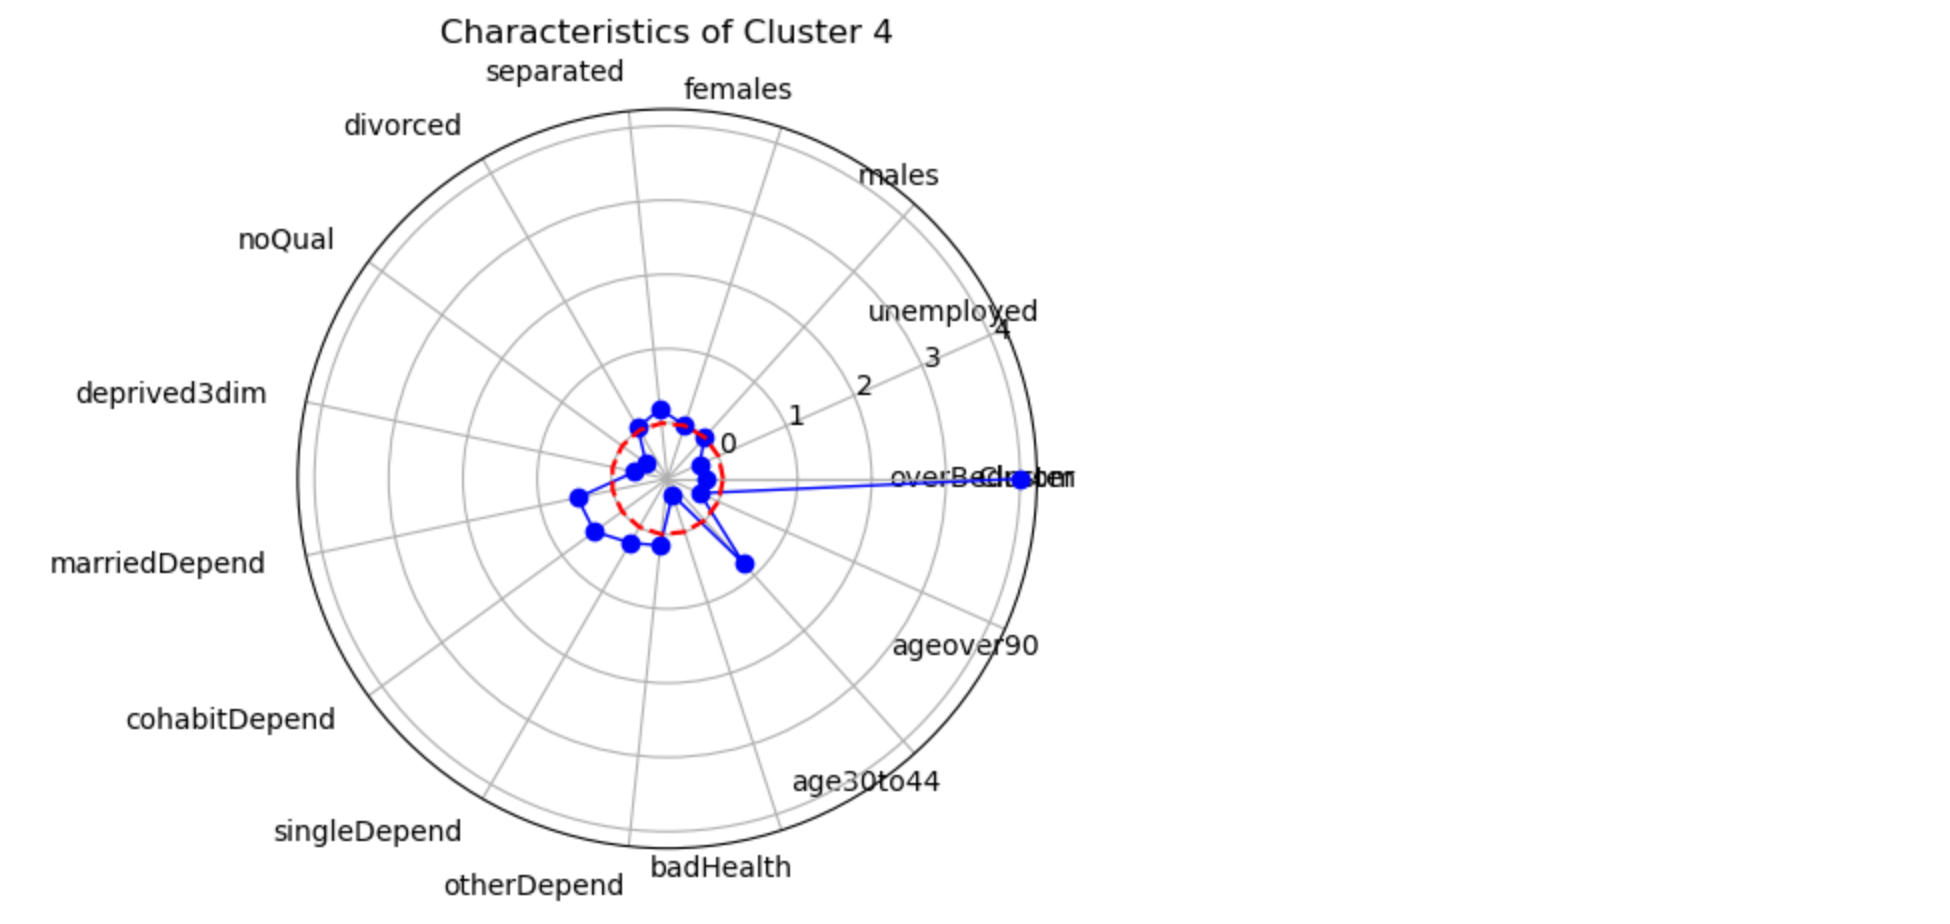
This cluster displays the characteristics of overcrowding but with a focus on individuals between ages 30 to 44 with dependent children (again mostly focusing on couples, but does include other and single-parent households). Where this cluster falls could indicate, where child support services need to be concentrated.

In [ ]:
# THE FIFTH CLUSTER
fifth_row_centers = cluster_centers.iloc[4, :]
num_features5 = len(fifth_row_centers)

theta5 = np.linspace(0, 2 * np.pi, num_features5, endpoint=True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta5, fifth_row_centers, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta5, np.zeros_like(fifth_row_centers), color='red', linestyle='--', label='Avarage')
ax.set_xticks(theta5)
ax.set_xticklabels(cluster_centers.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 5")
plt.show()

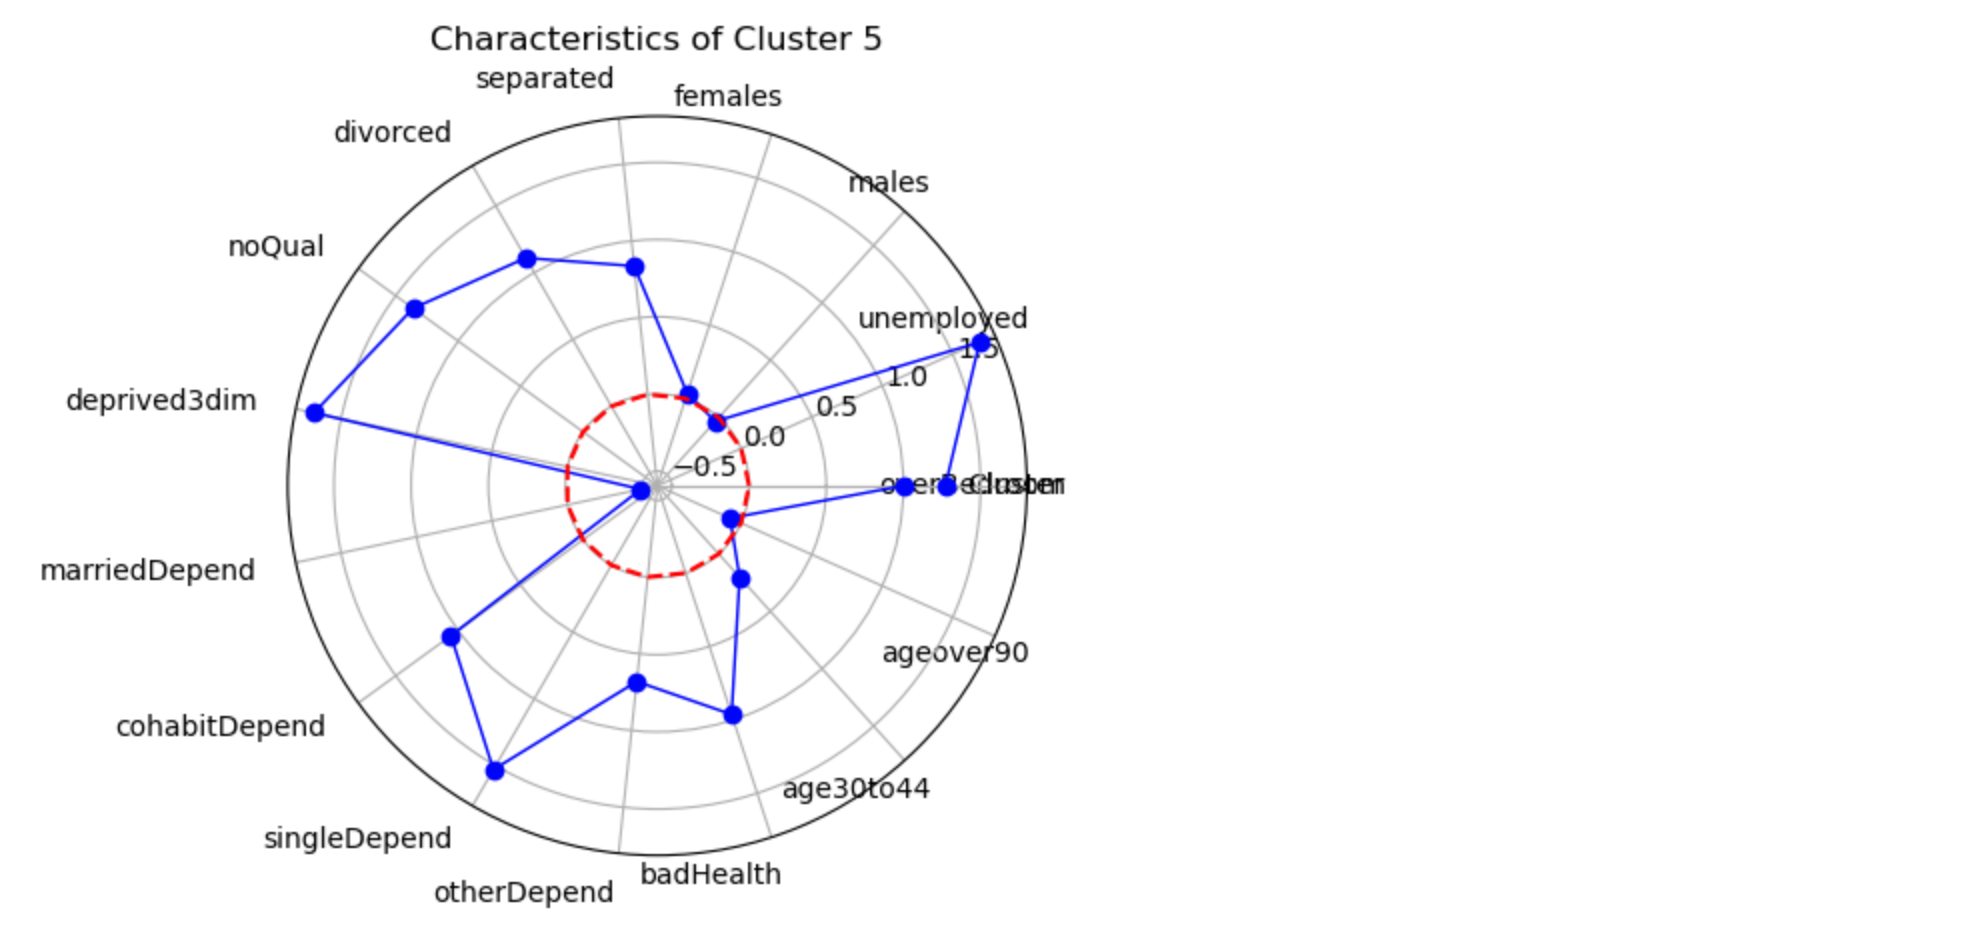
The final cluster appears to group households with positive correlations with most types of households other than married couples, with a high focus on unemployment and deprivation in other 3 dimensions.

**10. Map the final cluster groups**

To map the final clusters, we need to first get rid of our standardised percentages and return our original values. To do this we drop all of the values from our york_z_score dataframe, and then concatonate the cluster numbers left in the york_z_score dataframe with our original york_census_data dateframe to form our final dataframe!

In [ ]:
# reading in york_z_scores again
z_score_csv_path = "data/lab6/results/york_z_scores.csv"
york_z_scores_read = pd.read_csv(z_score_csv_path, low_memory=False)

In [ ]:
list(york_z_scores_read.columns) # listing the columns to see what we need to drop!

In [ ]:
york_z_scores_read.drop([
 'overBedroom',
 'unemployed',
 'males',
 'females',
 'separated',
 'divorced',
 'noQual',
 'deprived3dim',
 'marriedDepend',
 'cohabitDepend',
 'singleDepend',
 'otherDepend',
 'badHealth',
 'age30to44',
 'ageover90'
], axis=1, inplace=True)

york_z_scores_read.info()

In [ ]:
final_york_df = pd.concat([york_census_data, york_z_scores_read], axis=1, ignore_index=False)
final_york_df.head()

In [ ]:
final_york_df.columns # clusters at the end there looking lovely

**11. Finish the analysis by naming the final clusters and plotting a final map that includes the census values and the provided names.**


In [ ]:
# renaming the columns
def rename_column(x):
    x = x.replace("0", "Married household, Overcrowing")
    x = x.replace("1", "Men, aged 30 to 44, no dependents")
    x = x.replace("2", "Women, poor health, no qualifications, no dependents")
    x = x.replace("3", "Overcrowding, with dependents")
    x = x.replace("4", "Deprived, unemployed, with dependents")

In [ ]:
# and lets have a look at our final map!
final_york_df.explore(column='Cluster', cmap='Set1', tiles='CartoDB positron')

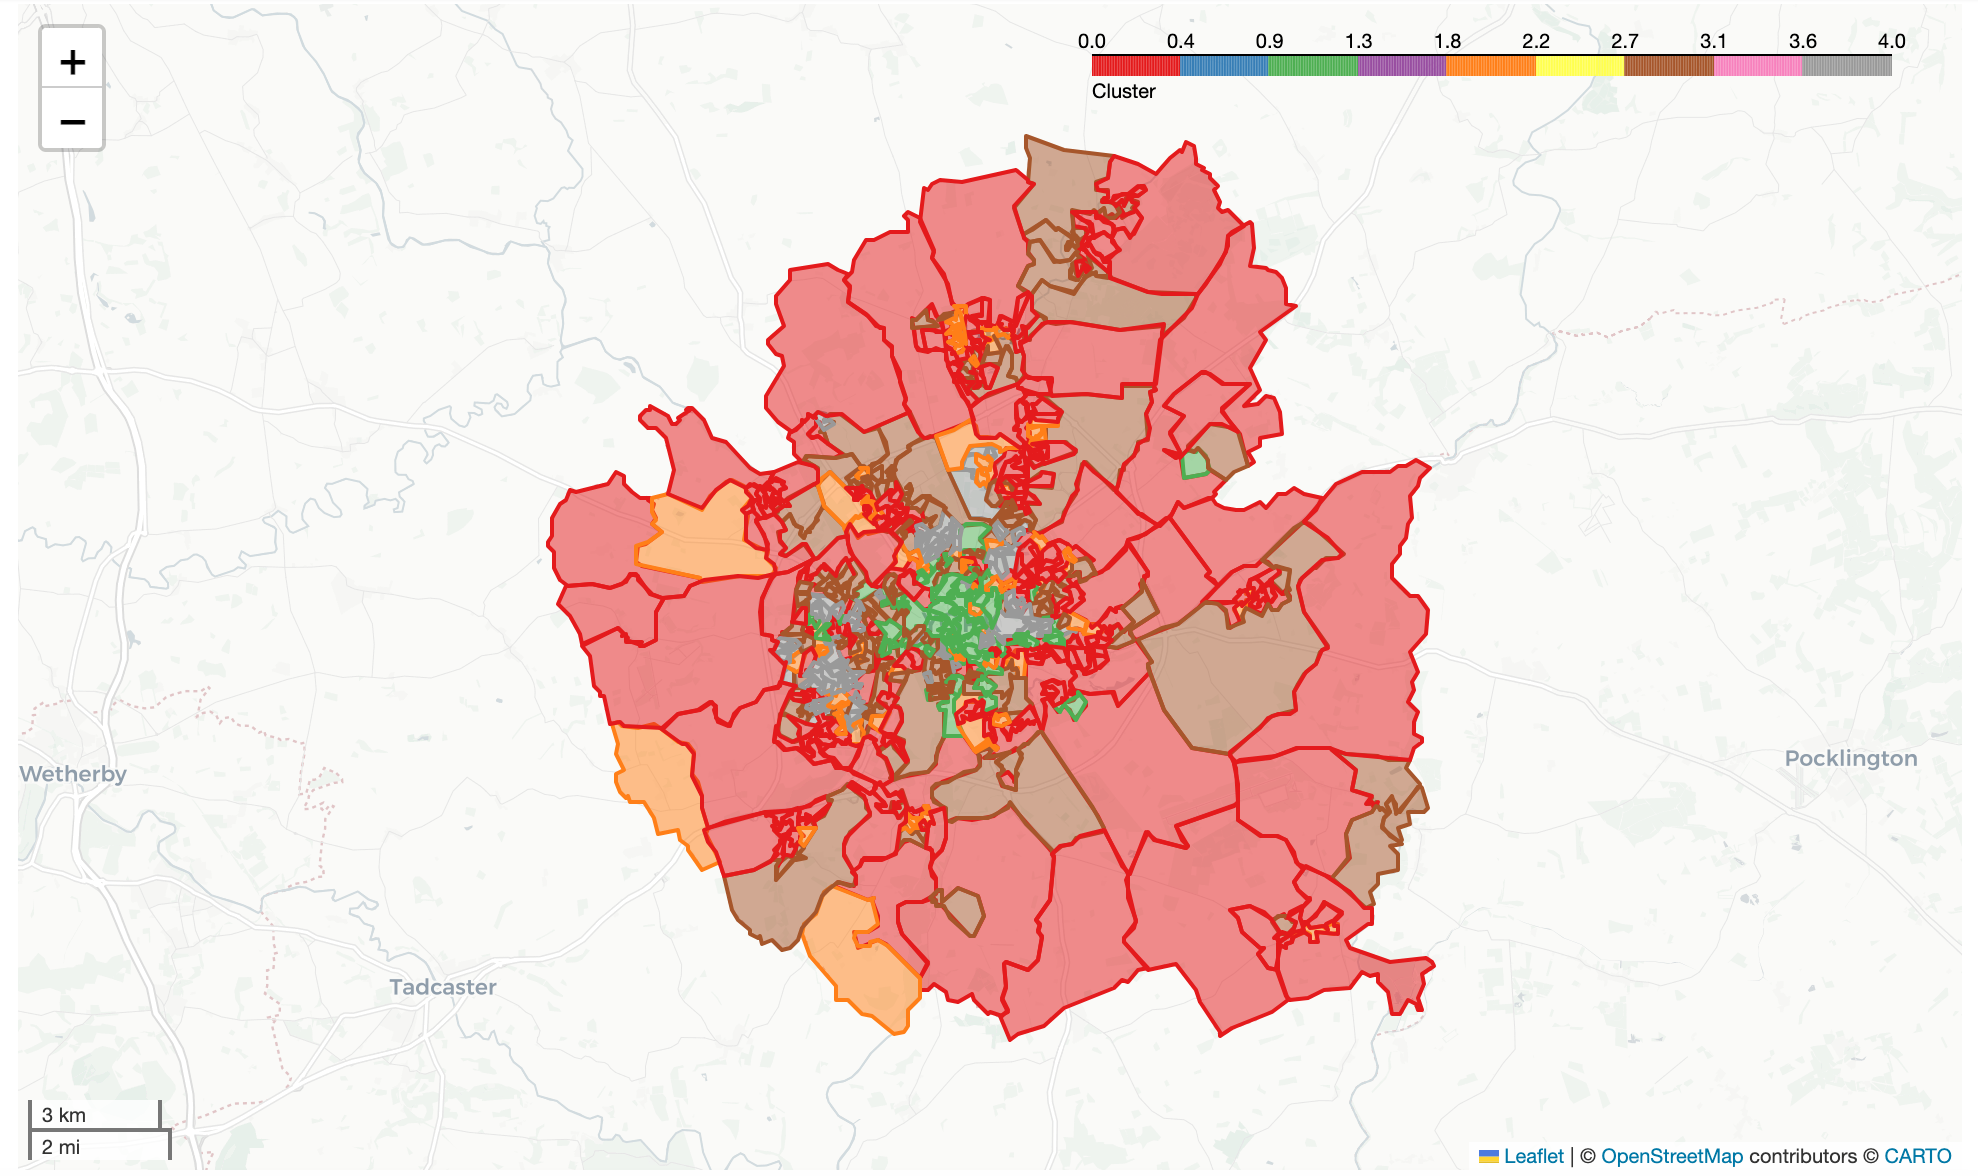

**12. Finally, acknowledge the subjective nature of classification and make analytical decisions to produce an optimum classification for your specific purpose. Reflect on the challenges and insights gained during the classification process. Ensure you document your analytical decisions and the rationale behind any important decision. Once your geodemographics are constructed, describe the potential use cases for the geodemographic classification you have built based on your initial goal.**

Classifications such as these have a completely subjective nature because of all of the choices and judgements creating a geodemographic classification requires. One might set out to achieve the same task as I've done here but choose to use a completely different set of variables, or manipulated the inital aggregate data differently. Furthermore, two individuals can set out with the same data and same task, but the produce clusters will still be different due to different analytical decisions being made. Or different characteristics within the clusters being observed to be more important. 

I faced several difficults within this task, some of which are already mentioned within my <a href="Info Page.ipynb#Final-thoughts">final thoughts</a> of this assignment over this assignment. Upon reflection, I believe that a couple of my clusters might be more effective if they were broken down into more clusters, e.g., the fifth cluster appears to include a large number of characteristics, and the first cluster (represented in red) encompasses a large area of the city (though many of these are larger output areas). However, several constrainst (including time and difficulties with changing clusters that I've already addressed in this notebook and the introductory page) meant that I elected to settle with the clusters as they are at the moment. 

I believe that analytical decisions made up until the structuring of the clusters themselves were all sound, although it might have been interesting to factor in more data for individuals without any dependents at all, as that is absent from my selections and might have aided with the formation of clusters. Once I started with the k-means clustering, things became a little muddled. I would have liked to have gone back and tested more numbers of clusters and experiments with splitting un the bigs ones and joining the smaller ones, but the sorting through difficulties mentioned above restricted how much time I had left to play with different cluster sizes. 

I set out to create a geodemographic classification of the city of York, attempting to create clusters to define characteristics that indicate that a household may be in need of further social support, e.g., through childcare, income support or support with re-entering the workforce etcetera. The classification system created here has its flaws, but should be able to adequately indicate where support might be required for the first example. The clusters do define where there are increased household with dependents, and so this can be used to decide where to concentrate further support to parents, new childcare and support schemes etc. But of course with the difficulties faced over the course of constructing these clusters, any results should be taken with a grain of salt!

---

## References:

- UK Data Service (2011) *Infuse*. Available at: http://infuse.ukdataservice.ac.uk/. (Accessed on: 9th March 2024).
- UK Data Service (2024) *Boundary Data Selector*. Available at: https://borders.ukdataservice.ac.uk/bds.html. (Accessed on: 10th March 2024).